# Predicting Monthly Electricity Consumption 

Predicting US monthly electricity consumption(sold) by State. 

Data: 
- Retail_sales_of_electricity from https://www.eia.gov 
- Average retail price of electricity https://www.eia.gov 
- GPD and econometric data from https://apps.bea.gov/regional/downloadzip.cfm
- Economic profile from BEA and https://fred.stlouisfed.org
- Monthly temperature by state https://www.ncdc.noaa.gov/ushcn/data-access 
- Population data from https://fred.stlouisfed.org 

The result will be compared to short term energy outlook report (STEO) from EIA. 


# Boiler Plate Section

In [41]:
# import the library
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold

from IPython.display import display
import matplotlib.dates as mdates
import seaborn as sns

from bokeh.io import output_file, output_notebook, show,curdoc, reset_output,export_png
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, CategoricalColorMapper, Slider, DateRangeSlider,
    DateSlider, SingleIntervalTicker, LinearAxis,Legend, LegendItem, Label
)
from bokeh.models.markers import Asterisk
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import STAMEN_TERRAIN,CARTODBPOSITRON_RETINA
from bokeh.layouts import widgetbox,row, column, gridplot

output_notebook()

Loading BokehJS ...

In [2]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'
mfolder = 'E:/Users/Fern/energy_data/'

In [303]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia':'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [40]:
import simplejson as json
with open(mfolder+'us_state_map.geojson','r') as fp:
    statedata = json.load(fp)

In [ ]:
blues = ['#FFF7FB', '#ECE7F2', '#D0D1E6', '#A6BDDB', '#74A9CF',
         '#3690C0', '#0570B0', '#045A8D', '#023858']
_color_idx = 0

def draw_polygon(subplot, coords, **kwargs):
    xs, ys = zip(*coords)
    kwargs['alpha']=0.5
    subplot.fill(xs, ys, **kwargs)

In [53]:
from collections import defaultdict

state2poly = defaultdict(list)
for f in statedata['features']:
    state = f['properties']['STUSPS']
    geo = f['geometry']
    for coords in geo['coordinates']:
        state2poly[state].append(coords)


In [55]:
def draw_state(subplot, name, **kwargs):
    """
    draw_state(subplot, state, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.  *state* is state abbreviation
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    kwargs['color'] = "#FFFFFF"
    for polygon in state2poly[name]:
        draw_polygon(subplot, polygon, **kwargs)

# Cleaning up electricity data 

I obtained report sales, revenue, number of account and prices from two section of EIA website. sale_revenue_by_state.csv contain all records all the way back to 1990, but lack the recent data. Other sets are from the EIA's interactive web with each number on separate tables. 

- Inspect of the data are consistent
- convert unit 
- Merge data from two sets for each types. 

In [43]:
sale_rev = pd.read_csv('E:/Users/Fern/energy_data/energy/sale_revenue_by_state.csv',header=[0,1])
sale_rev.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
                Year              Month              State             Status   
0               1990                  1                 AK              Final   
1               1990                  1                 AL              Final   
2               1990                  1                 AR              Final   
3               1990                  1                 AZ              Final   
4               1990                  1                 CA              Final   

   RESIDENTIAL Unnamed: 5_level_0 Unnamed: 6_level_0 Unnamed: 7_level_0  \
  Revenue(1k$)         Sales(MWh)    Customers_count   Price(c_per_kWh)   
0        17477             181752                  0               9.62   
1       123332            2070093                  0               5.96   
2        72506            1026320                  0               7.06   
3       109332            1396499                  0               7.83   
4       597161            6168009                  0               9.68   

    COMMERCIAL Unnamed: 9_level_0  ... Unnamed: 18_level_0  \
  Revenue(1k$)         Sales(MWh)  ...     Customers_count   
0        15818             178259  ...                   0   
1        54495             820415  ...                   0   
2        30966             474988  ...                   0   
3        82694            1081793  ...                   0   
4       508517            6011774  ...                   0   

  Unnamed: 19_level_0        OTHER Unnamed: 21_level_0 Unnamed: 22_level_0  \
     Price(c_per_kWh) Revenue(1k$)          Sales(MWh)     Customers_count   
0                 0.0         1918               14816                   0   
1                 0.0         2851               53954                   0   
2                 0.0         3117               47600                   0   
3                 0.0         7833              151064                   0   
4                 0.0        32100              869565                   0   

  Unnamed: 23_level_0        TOTAL Unnamed: 25_level_0 Unnamed: 26_level_0  \
     Price(c_per_kWh) Revenue(1k$)          Sales(MWh)     Customers_count   
0               12.95        38848              416438                   0   
1                5.28       268440             5044008                   0   
2                6.55       143635             2331399                   0   
3                5.19       243133             3439153                   0   
4                3.69      1406536            17504013                   0   

  Unnamed: 27_level_0  
     Price(c_per_kWh)  
0                9.33  
1                5.32  
2                6.16  
3                7.07  
4                8.04  

[5 rows x 28 columns]

In [44]:
sale_rev.tail()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
                    Year              Month              State   
17794               2019                  1                 VT   
17795               2019                  1                 WA   
17796               2019                  1                 WI   
17797               2019                  1                 WV   
17798               2019                  1                 WY   

      Unnamed: 3_level_0  RESIDENTIAL Unnamed: 5_level_0 Unnamed: 6_level_0  \
                  Status Revenue(1k$)         Sales(MWh)    Customers_count   
17794        Preliminary        36985             221058             315437   
17795        Preliminary       379753            4079098            3112054   
17796        Preliminary       309640            2211456            2745830   
17797        Preliminary       128466            1321849             860777   
17798        Preliminary        34776             329320             275961   

      Unnamed: 7_level_0   COMMERCIAL Unnamed: 9_level_0  ...  \
        Price(c_per_kWh) Revenue(1k$)         Sales(MWh)  ...   
17794              16.73        27029             173745  ...   
17795               9.31       229187            2643971  ...   
17796              14.00       215160            2014906  ...   
17797               9.72        59296             707239  ...   
17798              10.56        30874             339003  ...   

      Unnamed: 18_level_0 Unnamed: 19_level_0        OTHER  \
          Customers_count    Price(c_per_kWh) Revenue(1k$)   
17794                   0                0.00            0   
17795                   6               10.04            0   
17796                   2               13.48            0   
17797                   0                0.00            0   
17798                   0                0.00            0   

      Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
               Sales(MWh)     Customers_count    Price(c_per_kWh)   
17794                   0                   0                 0.0   
17795                   0                   0                 0.0   
17796                   0                   0                 0.0   
17797                   0                   0                 0.0   
17798                   0                   0                 0.0   

             TOTAL Unnamed: 25_level_0 Unnamed: 26_level_0 Unnamed: 27_level_0  
      Revenue(1k$)          Sales(MWh)     Customers_count    Price(c_per_kWh)  
17794        77567              521061              372650               14.89  
17795       710159             8891622             3538970                7.99  
17796       671988             6190346             3111199               10.86  
17797       259764             3270054             1017136                7.94  
17798       122490             1550021              344681                7.90  

[5 rows x 28 columns]

In [45]:
sale_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17799 entries, 0 to 17798
Data columns (total 28 columns):
(Unnamed: 0_level_0, Year)                 17799 non-null int64
(Unnamed: 1_level_0, Month)                17799 non-null int64
(Unnamed: 2_level_0, State)                17799 non-null object
(Unnamed: 3_level_0, Status)               17799 non-null object
(RESIDENTIAL, Revenue(1k$))                17799 non-null int64
(Unnamed: 5_level_0, Sales(MWh))           17799 non-null int64
(Unnamed: 6_level_0, Customers_count)      17799 non-null int64
(Unnamed: 7_level_0, Price(c_per_kWh))     17799 non-null float64
(COMMERCIAL, Revenue(1k$))                 17799 non-null int64
(Unnamed: 9_level_0, Sales(MWh))           17799 non-null int64
(Unnamed: 10_level_0, Customers_count)     17799 non-null int64
(Unnamed: 11_level_0, Price(c_per_kWh))    17799 non-null float64
(INDUSTRIAL, Revenue(1k$))                 17799 non-null int64
(Unnamed: 13_level_0, Sales(MWh))          17799 non-

Need to clean up columns name

In [46]:
cols = sale_rev.columns

In [66]:
newcol = []
for i, col in enumerate(cols):
    if (i % 4) == 0:
        title = col[0]
    
    if i < 3:
        newcol.append(col[1])
    else:
        newcol.append(title[:3]+'_'+col[1])

In [67]:
sale_rev.columns = newcol

In [68]:
sale_rev.tail()

Year  Month State   Unn_Status  RES_Revenue(1k$)  RES_Sales(MWh)  \
17794  2019      1    VT  Preliminary             36985          221058   
17795  2019      1    WA  Preliminary            379753         4079098   
17796  2019      1    WI  Preliminary            309640         2211456   
17797  2019      1    WV  Preliminary            128466         1321849   
17798  2019      1    WY  Preliminary             34776          329320   

       RES_Customers_count  RES_Price(c_per_kWh)  COM_Revenue(1k$)  \
17794               315437                 16.73             27029   
17795              3112054                  9.31            229187   
17796              2745830                 14.00            215160   
17797               860777                  9.72             59296   
17798               275961                 10.56             30874   

       COM_Sales(MWh)  ...  TRA_Customers_count  TRA_Price(c_per_kWh)  \
17794          173745  ...                    0                  0.00   
17795         2643971  ...                    6                 10.04   
17796         2014906  ...                    2                 13.48   
17797          707239  ...                    0                  0.00   
17798          339003  ...                    0                  0.00   

       OTH_Revenue(1k$)  OTH_Sales(MWh)  OTH_Customers_count  \
17794                 0               0                    0   
17795                 0               0                    0   
17796                 0               0                    0   
17797                 0               0                    0   
17798                 0               0                    0   

       OTH_Price(c_per_kWh)  TOT_Revenue(1k$)  TOT_Sales(MWh)  \
17794                   0.0             77567          521061   
17795                   0.0            710159         8891622   
17796                   0.0            671988         6190346   
17797                   0.0            259764         3270054   
17798                   0.0            122490         1550021   

       TOT_Customers_count  TOT_Price(c_per_kWh)  
17794               372650                 14.89  
17795              3538970                  7.99  
17796              3111199                 10.86  
17797              1017136                  7.94  
17798               344681                  7.90  

[5 rows x 28 columns]

In [230]:
sale_rev.describe()

Year         Month  RES_Revenue(1k$)  RES_Sales(MWh)  \
count  17799.000000  17799.000000      1.779900e+04    1.779900e+04   
mean    2004.042980      6.484241      2.075218e+05    2.034171e+06   
std        8.393226      3.459714      2.500146e+05    2.156849e+06   
min     1990.000000      1.000000      4.708000e+03    7.388100e+04   
25%     1997.000000      3.000000      4.757450e+04    4.663850e+05   
50%     2004.000000      6.000000      1.268890e+05    1.476609e+06   
75%     2011.000000      9.000000      2.618990e+05    2.739044e+06   
max     2019.000000     12.000000      2.443657e+06    1.862066e+07   

       RES_Customers_count  RES_Price(c_per_kWh)  COM_Revenue(1k$)  \
count         1.779900e+04          17799.000000      1.779900e+04   
mean          1.029424e+06             10.178624      1.687193e+05   
std           2.056480e+06              3.788402      2.248017e+05   
min           0.000000e+00              4.180000      0.000000e+00   
25%           0.000000e+00              7.520000      3.944450e+04   
50%           0.000000e+00              9.420000      9.017700e+04   
75%           1.287832e+06             11.850000      2.052800e+05   
max           1.397101e+07             40.160000      2.308117e+06   

       COM_Sales(MWh)  COM_Customers_count  COM_Price(c_per_kWh)  ...  \
count    1.779900e+04         1.779900e+04          17799.000000  ...   
mean     1.854756e+06         1.432707e+05              8.717945  ...   
std      2.008221e+06         2.798574e+05              3.279133  ...   
min      0.000000e+00         0.000000e+00              0.000000  ...   
25%      4.801630e+05         0.000000e+00              6.510000  ...   
50%      1.223551e+06         0.000000e+00              8.070000  ...   
75%      2.374109e+06         1.921810e+05              9.970000  ...   
max      1.446088e+07         1.897985e+06             37.210000  ...   

       TRA_Customers_count  TRA_Price(c_per_kWh)  OTH_Revenue(1k$)  \
count         17799.000000          17799.000000      17799.000000   
mean              2.219563              2.698180       4948.239508   
std              23.079422              4.562531      13116.323140   
min               0.000000              0.000000          0.000000   
25%               0.000000              0.000000          0.000000   
50%               0.000000              0.000000          0.000000   
75%               0.000000              6.685000       4269.500000   
max             520.000000            116.670000     120161.000000   

       OTH_Sales(MWh)  OTH_Customers_count  OTH_Price(c_per_kWh)  \
count    1.779900e+04              17799.0          17799.000000   
mean     7.343562e+04                  0.0              3.642525   
std      1.872142e+05                  0.0              4.786899   
min      0.000000e+00                  0.0              0.000000   
25%      0.000000e+00                  0.0              0.000000   
50%      0.000000e+00                  0.0              0.000000   
75%      5.740550e+04                  0.0              6.690000   
max      1.639053e+06                  0.0             48.800000   

       TOT_Revenue(1k$)  TOT_Sales(MWh)  TOT_Customers_count  \
count      1.779900e+04    1.779900e+04         1.779900e+04   
mean       4.747362e+05    5.600202e+06         1.179033e+06   
std        5.495824e+05    5.437331e+06         2.347576e+06   
min        2.538900e+04    3.020170e+05         0.000000e+00   
25%        1.168845e+05    1.534200e+06         0.000000e+00   
50%        2.977780e+05    4.203282e+06         0.000000e+00   
75%        6.020725e+05    7.630984e+06         1.525284e+06   
max        5.541783e+06    4.252625e+07         1.587646e+07   

       TOT_Price(c_per_kWh)  
count          17799.000000  
mean               8.493965  
std                3.442677  
min                3.060000  
25%                6.140000  
50%                7.780000  
75%                9.885000  
max               36.3700

### Revenue

Data in 2019 Jan and Feb are not update, need to import from other files.
also serve as a cross reference
- Data in Million

In [185]:
sale_rev.columns[sale_rev.columns.str.contains('Rev')]

Index(['RES_Revenue(1k$)', 'COM_Revenue(1k$)', 'IND_Revenue(1k$)',
       'TRA_Revenue(1k$)', 'OTH_Revenue(1k$)', 'TOT_Revenue(1k$)'],
      dtype='object')

In [208]:
# load revenu data from another file
rev = pd.read_csv('E:/Users/Fern/energy_data/energy/Revenue_from_retail_sales_of_electricity.csv',skiprows=5).drop(0)
rev.head()

Revenue from retail sales of electricity  million dollars  \
1              United States : all sectors  million dollars   
2              United States : residential  million dollars   
3               United States : commercial  million dollars   
4               United States : industrial  million dollars   
5           United States : transportation  million dollars   

          source key Jan 2001 Feb 2001 Mar 2001 Apr 2001 May 2001 Jun 2001  \
1  ELEC.REV.US-ALL.M    20978    18700    18880    17856    18970    21977   
2  ELEC.REV.US-RES.M     9827     8030     7721     6974     7217     9014   
3  ELEC.REV.US-COM.M     6587     6119     6470     6269     6794     7779   
4  ELEC.REV.US-IND.M     3952     3945     4061     4006     4303     4458   
5  ELEC.REV.US-TRA.M       --       --       --       --       --       --   

  Jul 2001  ... May 2018 Jun 2018 Jul 2018 Aug 2018 Sep 2018 Oct 2018  \
1    24876  ...    31029    35963    40773    41631    35519    31830   
2    10901  ...    13600    16889    20094    20306    16710    13720   
3     8592  ...    11821    13156    14370    14794    12986    12452   
4     4631  ...     5553     5854     6243     6464     5757     5596   
5       --  ...       56       64       65       66       67       63   

  Nov 2018 Dec 2018 Jan 2019 Feb 2019  
1    29789    31538    33266    30474  
2    13384    15285    16580    14768  
3    11051    11122    11484    10801  
4     5293     5066     5138     4838  
5       60       64       65       68  

[5 rows x 221 columns]

In [209]:
rev['state_sector'] = rev['source key'].str.split('.',n=4, expand=True)[2]

In [210]:
rev['state_sector'].head()

1    US-ALL
2    US-RES
3    US-COM
4    US-IND
5    US-TRA
Name: state_sector, dtype: object

In [211]:
# extract state and sector 
rev['Sector'] = rev['state_sector'].str.split('-',n=2, expand=True)[1]
rev['State'] = rev['state_sector'].str.split('-',n=2, expand=True)[0]

In [212]:
rev['State'].tail()

429    HI
430    HI
431    HI
432    HI
433    HI
Name: State, dtype: object

In [213]:
rev['Sector'].unique()

array(['ALL', 'RES', 'COM', 'IND', 'TRA', 'OTH'], dtype=object)

In [214]:
# keep only the state 
rev = rev[rev['State'].str.len()==2]
rev = rev[rev['State'] != 'US']

In [215]:
len(rev['State'].unique())

51

In [216]:
rev = rev.drop(['million dollars','source key','state_sector','Revenue from retail sales of electricity'],axis=1).dropna()

In [217]:
rev.head()

Jan 2001 Feb 2001 Mar 2001 Apr 2001 May 2001 Jun 2001 Jul 2001 Aug 2001  \
15      269      221      242      215      226      254      262      296   
16      139      101      112       95       87      105      118      136   
17       97       80       93       85       97      102      105      114   
18       29       36       32       31       39       43       34       41   
19       --       --       --       --       --       --       --       --   

   Sep 2001 Oct 2001  ... Jul 2018 Aug 2018 Sep 2018 Oct 2018 Nov 2018  \
15      233      230  ...      537      546      450      399      408   
16      100       91  ...      305      298      231      185      210   
17       94       96  ...      193      205      180      175      162   
18       34       38  ...       36       41       37       37       35   
19       --       --  ...        2        2        2        2        2   

   Dec 2018 Jan 2019 Feb 2019 Sector State  
15      453      494      440    ALL    CT  
16      246      272      239    RES    CT  
17      172      184      165    COM    CT  
18       33       36       33    IND    CT  
19        2        2        2    TRA    CT  

[5 rows x 220 columns]

In [84]:
len(rev)

306

There are 51 states and 6 sectors each, thus 306 columns.

Want to pivot the sectors into columns and date-year into row. 

In [218]:
temp = rev.melt(id_vars=['State','Sector'])
temp.columns = ['State','Sector','date','rev']
temp.head()

State Sector      date  rev
0    CT    ALL  Jan 2001  269
1    CT    RES  Jan 2001  139
2    CT    COM  Jan 2001   97
3    CT    IND  Jan 2001   29
4    CT    TRA  Jan 2001   --

In [220]:
rev_pivot = pd.pivot_table(temp,index=['date','State'],values='rev',columns=['Sector'],aggfunc='last').reset_index()
rev_pivot['Year'] = rev_pivot['date'].str.split(' ',n=2,expand=True)[1].astype(int)
rev_pivot['Month'] = rev_pivot['date'].str.split(' ',n=2,expand=True)[0]
rev_pivot['Month'] =  pd.to_datetime(rev_pivot['Month'], format='%b').dt.month
rev_pivot.sort_values(['Year','Month','State'],inplace=True)

In [221]:
# cross check with sale_rev table 
rev_pivot[(rev_pivot['Year']==2019 )& (rev_pivot['Month']==1) ]

Sector      date State   ALL   COM  IND OTH   RES TRA  Year  Month
4641    Jan 2019    AK   112    48   17  --    47   0  2019      1
4642    Jan 2019    AL   714   202  155  --   358   0  2019      1
4643    Jan 2019    AR   323    79   81  --   162   0  2019      1
4644    Jan 2019    AZ   583   215   66  --   302   0  2019      1
4645    Jan 2019    CA  3266  1361  392  --  1507   5  2019      1
4646    Jan 2019    CO   457   163   90  --   203   1  2019      1
4647    Jan 2019    CT   494   184   36  --   272   2  2019      1
4648    Jan 2019    DC   118    84    1  --    30   3  2019      1
4649    Jan 2019    DE   109    37   13  --    59   0  2019      1
4650    Jan 2019    FL  1861   682   99  --  1080   1  2019      1
4651    Jan 2019    GA  1069   360  141  --   568   1  2019      1
4652    Jan 2019    HI   222    72   76  --    74   0  2019      1
4653    Jan 2019    IA   388   101  115  --   172   0  2019      1
4654    Jan 2019    ID   163    42   29  --    91   0  2019      1
4655    Jan 2019    IL  1149   374  241  --   531   3  2019      1
4656    Jan 2019    IN   853   212  244  --   396   0  2019      1
4657    Jan 2019    KS   292   103   64  --   125   0  2019      1
4658    Jan 2019    KY   560   155  124  --   281   0  2019      1
4659    Jan 2019    LA   539   164  143  --   231   0  2019      1
4660    Jan 2019    MA   867   381   71  --   413   3  2019      1
4661    Jan 2019    MD   677   261   24  --   389   4  2019      1
4662    Jan 2019    ME   143    45   21  --    77   0  2019      1
4663    Jan 2019    MI  1021   361  179  --   481   0  2019      1
4664    Jan 2019    MN   612   196  129  --   287   0  2019      1
4665    Jan 2019    MO   598   208   55  --   334   0  2019      1
4666    Jan 2019    MS   383   111   86  --   185   0  2019      1
4667    Jan 2019    MT   126    44   21  --    61   0  2019      1
4668    Jan 2019    NC  1105   339  128  --   638   0  2019      1
4669    Jan 2019    ND   175    55   64  --    56   0  2019      1
4670    Jan 2019    NE   228    69   57  --   102   0  2019      1
4671    Jan 2019    NH   177    62   22  --    92   0  2019      1
4672    Jan 2019    NJ   830   382   58  --   388   2  2019      1
4673    Jan 2019    NM   185    67   36  --    81   0  2019      1
4674    Jan 2019    NV   220    65   47  --   108   0  2019      1
4675    Jan 2019    NY  1703   813   82  --   777  31  2019      1
4676    Jan 2019    OH  1277   384  261  --   632   0  2019      1
4677    Jan 2019    OK   388   116   77  --   195   0  2019      1
4678    Jan 2019    OR   403   121   61  --   221   0  2019      1
4679    Jan 2019    PA  1318   327  273  --   713   5  2019      1
4680    Jan 2019    RI   131    57   10  --    63   0  2019      1
4681    Jan 2019    SC   637   167  132  --   338   0  2019      1
4682    Jan 2019    SD   110    39   16  --    55   0  2019      1
4683    Jan 2019    TN   828   308   95  --   425   0  2019      1
4684    Jan 2019    TX  2772   852  481  --  1438   1  2019      1
4685    Jan 2019    UT   202    76   40  --    85   0  2019      1
4686    Jan 2019    VA  1038   377   94  --   564   1  2019      1
4687    Jan 2019    VT    78    27   14  --    37   0  2019      1
4688    Jan 2019    WA   710   229  101  --   380   0  2019      1
4689    Jan 2019    WI   672   215  147  --   310   0  2019      1
4690    Jan 2019    WV   260    59   72  --   128   0  2019      1
4691    Jan 2019    WY   122    31   57  --    35   0  2019      1

In [236]:
rev_cols = ['Year','Month','State']+list(sale_rev.columns[sale_rev.columns.str.contains('Rev')])
revold = sale_rev[rev_cols].sort_values(['Year','Month','State']).copy()

In [222]:
revold[(revold['Year']==2019 )& (revold['Month']==1) ]

Year  Month State  RES_Revenue(1k$)  COM_Revenue(1k$)  \
17748  2019      1    AK             46843             48246   
17749  2019      1    AL            357710            201581   
17750  2019      1    AR            162393             79477   
17751  2019      1    AZ            302353            215060   
17752  2019      1    CA           1507350           1361480   
17753  2019      1    CO            202764            163399   
17754  2019      1    CT            271765            184219   
17755  2019      1    DC             29895             83909   
17756  2019      1    DE             58706             36507   
17757  2019      1    FL           1079893            681610   
17758  2019      1    GA            567969            359518   
17759  2019      1    HI             73804             71881   
17760  2019      1    IA            171682            101100   
17761  2019      1    ID             91389             42422   
17762  2019      1    IL            530994            373533   
17763  2019      1    IN            396472            212215   
17764  2019      1    KS            124994            102986   
17765  2019      1    KY            280783            154857   
17766  2019      1    LA            231354            164169   
17767  2019      1    MA            412852            380750   
17768  2019      1    MD            388789            260504   
17769  2019      1    ME             77161             44832   
17770  2019      1    MI            480958            361132   
17771  2019      1    MN            286741            195922   
17772  2019      1    MO            334398            208054   
17773  2019      1    MS            185150            111220   
17774  2019      1    MT             61369             44026   
17775  2019      1    NC            637835            339027   
17776  2019      1    ND             56446             54920   
17777  2019      1    NE            101675             69224   
17778  2019      1    NH             92286             62353   
17779  2019      1    NJ            387970            381505   
17780  2019      1    NM             81411             67309   
17781  2019      1    NV            108083             65117   
17782  2019      1    NY            777029            813409   
17783  2019      1    OH            631963            384350   
17784  2019      1    OK            195409            115873   
17785  2019      1    OR            220931            120933   
17786  2019      1    PA            713027            326818   
17787  2019      1    RI             63403             57332   
17788  2019      1    SC            338455            167356   
17789  2019      1    SD             54915             38727   
17790  2019      1    TN            425270            307596   
17791  2019      1    TX           1437964            852249   
17792  2019      1    UT             85065             76131   
17793  2019      1    VA            564402            377417   
17794  2019      1    VT             36985             27029   
17795  2019      1    WA            379753            229187   
17796  2019      1    WI            309640            215160   
17797  2019      1    WV            128466             59296   
17798  2019      1    WY             34776             30874   

       IND_Revenue(1k$)  TRA_Revenue(1k$)  OTH_Revenue(1k$)  TOT_Revenue(1k$)  
17748             16543                 0                 0            111633  
17749            154620                 0                 0            713910  
17750             80921                 4                 0            322796  
17751             65753                59                 0            583225  
17752            391979              5036                 0           3265845  
17753             90308               809                 0            457280  
17754             36080              2242                 0            494305  
17755              1043              2

The number check out. revold data are correct, just missing data from Feb 2019. 

In [234]:
list(sale_rev.columns[sale_rev.columns.str.contains('Rev')])

['RES_Revenue(1k$)',
 'COM_Revenue(1k$)',
 'IND_Revenue(1k$)',
 'TRA_Revenue(1k$)',
 'OTH_Revenue(1k$)',
 'TOT_Revenue(1k$)']

In [237]:
# round number to millions
rev_cols = list(sale_rev.columns[sale_rev.columns.str.contains('Rev')])
for rev_col in rev_cols: 
    revold.loc[:,rev_col] = (revold.loc[:,rev_col]/1000).round(2)

revold.head()

Year  Month State  RES_Revenue(1k$)  COM_Revenue(1k$)  IND_Revenue(1k$)  \
0  1990      1    AK             17.48             15.82              3.64   
1  1990      1    AL            123.33             54.50             87.76   
2  1990      1    AR             72.51             30.97             37.05   
3  1990      1    AZ            109.33             82.69             43.27   
4  1990      1    CA            597.16            508.52            268.76   

   TRA_Revenue(1k$)  OTH_Revenue(1k$)  TOT_Revenue(1k$)  
0               0.0              1.92             38.85  
1               0.0              2.85            268.44  
2               0.0              3.12            143.64  
3               0.0              7.83            243.13  
4               0.0             32.10           1406.54

In [238]:
revold.columns

Index(['Year', 'Month', 'State', 'RES_Revenue(1k$)', 'COM_Revenue(1k$)',
       'IND_Revenue(1k$)', 'TRA_Revenue(1k$)', 'OTH_Revenue(1k$)',
       'TOT_Revenue(1k$)'],
      dtype='object')

In [241]:
revold.columns = ['Year', 'Month', 'State', 'RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']

In [259]:
temp = rev_pivot[revold.columns]
temp = temp[(temp['Year']==2019 )&(temp['Month']==2) ]
temp['OTH'] = temp['OTH'].str.replace('--','0')
temp.head()

Sector  Year  Month State   RES   COM  IND TRA OTH   ALL
3672    2019      2    AK    41    45   17   0   0   103
3673    2019      2    AL   297   182  140   0   0   620
3674    2019      2    AR   153    76   78   0   0   308
3675    2019      2    AZ   271   203   65   0   0   539
3676    2019      2    CA  1241  1204  389   6   0  2840

In [262]:
revall = pd.concat([revold,temp])
revall.head()

Sector  Year  Month State     RES     COM     IND TRA   OTH      ALL
0       1990      1    AK   17.48   15.82    3.64   0  1.92    38.85
1       1990      1    AL  123.33    54.5   87.76   0  2.85   268.44
2       1990      1    AR   72.51   30.97   37.05   0  3.12   143.64
3       1990      1    AZ  109.33   82.69   43.27   0  7.83   243.13
4       1990      1    CA  597.16  508.52  268.76   0  32.1  1406.54

In [263]:
revall.tail()

Sector  Year  Month State  RES  COM  IND TRA OTH  ALL
3718    2019      2    VT   33   25   11   0   0   69
3719    2019      2    WA  367  217   96   1   0  680
3720    2019      2    WI  275  202  143   0   0  621
3721    2019      2    WV  109   54   67   0   0  231
3722    2019      2    WY   30   29   58   0   0  116

Electricity for Transportation has only be recored recently, so I combine them into other columns.

In [265]:
revall['OTH'] = revall['OTH'] + revall['TRA']
revall = revall.drop('TRA',axis=1)

In [266]:
revall.to_csv('E:/Users/Fern/energy_data/clean/revenue.csv',index=False)

In [267]:
revall = pd.read_csv('E:/Users/Fern/energy_data/clean/revenue.csv')
revall.head()

Year  Month State     RES     COM     IND    OTH      ALL
0  1990      1    AK   17.48   15.82    3.64   1.92    38.85
1  1990      1    AL  123.33   54.50   87.76   2.85   268.44
2  1990      1    AR   72.51   30.97   37.05   3.12   143.64
3  1990      1    AZ  109.33   82.69   43.27   7.83   243.13
4  1990      1    CA  597.16  508.52  268.76  32.10  1406.54

In [268]:
revall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17850 entries, 0 to 17849
Data columns (total 8 columns):
Year     17850 non-null int64
Month    17850 non-null int64
State    17850 non-null object
RES      17850 non-null float64
COM      17850 non-null float64
IND      17850 non-null float64
OTH      17850 non-null float64
ALL      17850 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.1+ MB


There are monthly data from 1990 to 2019 Feb, and from 51 states, thus 17850 rows.

In [270]:
((2018 - 1990+1)*12 + 2)*51

17850

### Sales


In [512]:
sale_rev.head(2)

Year  Month State Unn_Status  RES_Revenue(1k$)  RES_Sales(MWh)  \
0  1990      1    AK      Final             17477          181752   
1  1990      1    AL      Final            123332         2070093   

   RES_Customers_count  RES_Price(c_per_kWh)  COM_Revenue(1k$)  \
0                    0                  9.62             15818   
1                    0                  5.96             54495   

   COM_Sales(MWh)  ...  TRA_Customers_count  TRA_Price(c_per_kWh)  \
0          178259  ...                    0                   0.0   
1          820415  ...                    0                   0.0   

   OTH_Revenue(1k$)  OTH_Sales(MWh)  OTH_Customers_count  \
0              1918           14816                    0   
1              2851           53954                    0   

   OTH_Price(c_per_kWh)  TOT_Revenue(1k$)  TOT_Sales(MWh)  \
0                 12.95             38848          416438   
1                  5.28            268440         5044008   

   TOT_Customers_count  TOT_Price(c_per_kWh)  
0                    0                  9.33  
1                    0                  5.32  

[2 rows x 28 columns]

In [513]:
salecols = list(sale_rev.columns[sale_rev.columns.str.contains('Sales')])
salecols = ['Year','Month','State'] + salecols

In [514]:
saleold = sale_rev[salecols].copy()
saleold.columns = ['Year', 'Month', 'State', 'RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']
saleold.sort_values(['Year','Month','State'],inplace=True)

In [515]:
saleold.tail()

Year  Month State      RES      COM      IND  TRA  OTH      ALL
17794  2019      1    VT   221058   173745   126258    0    0   521061
17795  2019      1    WA  4079098  2643971  2167994  558    0  8891622
17796  2019      1    WI  2211456  2014906  1963573  412    0  6190346
17797  2019      1    WV  1321849   707239  1240966    0    0  3270054
17798  2019      1    WY   329320   339003   881697    0    0  1550021

In [516]:
# load sale data from another file
sale = pd.read_csv('E:/Users/Fern/energy_data/energy/Retail_sales_of_electricity.csv',skiprows=4)
sale.head()

description                  units           source key  \
0     United States : all sectors  million kilowatthours  ELEC.SALES.US-ALL.M   
1     United States : residential  million kilowatthours  ELEC.SALES.US-RES.M   
2      United States : commercial  million kilowatthours  ELEC.SALES.US-COM.M   
3      United States : industrial  million kilowatthours  ELEC.SALES.US-IND.M   
4  United States : transportation  million kilowatthours  ELEC.SALES.US-TRA.M   

  Jan 2001 Feb 2001 Mar 2001 Apr 2001 May 2001 Jun 2001 Jul 2001  ...  \
0   310816   272335   269298   254391   264490   290008   315798  ...   
1   127066    99878    92805    82454    81731    99407   120707  ...   
2    90825    81467    84064    81061    87471    95658   102156  ...   
3    83477    82248    83522    82253    86097    85269    83176  ...   
4       --       --       --       --       --       --       --  ...   

  May 2018 Jun 2018 Jul 2018 Aug 2018 Sep 2018 Oct 2018 Nov 2018 Dec 2018  \
0   298044   333212   369629   377748   331881   304157   285543   307171   
1   103395   129478   153031   152951   128459   106638   103372   122620   
2   112597   121578   130916   134479   121581   115861   104622   107678   
3    81461    81527    85041    89632    81192    81023    76927    76213   
4      591      628      640      686      648      636      622      660   

  Jan 2019 Feb 2019  
0   323300   292049  
1   132989   116311  
2   111613   102690  
3    78033    72371  
4      664      677  

[5 rows x 221 columns]

In [517]:
def get_state_sector(df,to_drop=3):
    # extract source_key
    df['state_sector'] = df['source key'].str.split('.',n=4, expand=True)[2]
    # extract state and sector 
    df['Sector'] = df['state_sector'].str.split('-',n=2, expand=True)[1]
    df['State'] = df['state_sector'].str.split('-',n=2, expand=True)[0]

    df = df.drop(df.columns[:to_drop],axis=1).dropna()
    
    # keep only the state 
    df = df[df['State'].str.len()==2]
    df = df[df['State'] != 'US']
    return df.drop('state_sector',axis=1) 

In [518]:
sale = get_state_sector(sale)

In [519]:
sale.head(2)

Jan 2001 Feb 2001 Mar 2001 Apr 2001 May 2001 Jun 2001 Jul 2001 Aug 2001  \
14     2760     2438     2577     2238     2363     2661     2674     2987   
15     1300      985     1054      872      776      945     1075     1216   

   Sep 2001 Oct 2001  ... Jul 2018 Aug 2018 Sep 2018 Oct 2018 Nov 2018  \
14     2399     2365  ...     2967     2975     2345     2170     2199   
15      896      802  ...     1462     1402     1049      844      992   

   Dec 2018 Jan 2019 Feb 2019 Sector State  
14     2408     2574     2218    ALL    CT  
15     1182     1260     1052    RES    CT  

[2 rows x 220 columns]

In [520]:
def pivot_data(df,name='value'):
    temp = df.melt(id_vars=['State','Sector'])
    temp.columns = ['State','Sector','date',name]
    temp.value = temp.value.str.replace('--','0')
       
    temp_pivot = pd.pivot_table(temp,index=['date','State'],values=name,columns=['Sector'],aggfunc='last').reset_index()
    #print(temp_pivot.head())
    temp_pivot['Year'] = temp_pivot['date'].str.split(' ',n=2,expand=True)[1].astype(int)
    temp_pivot['Month'] = temp_pivot['date'].str.split(' ',n=2,expand=True)[0]
    temp_pivot['Month'] =  pd.to_datetime(temp_pivot['Month'], format='%b').dt.month
    temp_pivot.drop('date',axis=1,inplace=True)
    temp_pivot.sort_values(['Year','Month','State'],inplace=True)
    return temp_pivot

In [521]:
sale_pivot = pivot_data(sale)
sale_pivot[(sale_pivot['Year']==2019)&(sale_pivot['Month']==1)].head()

Sector State    ALL   COM   IND OTH   RES TRA  Year  Month
4641      AK    564   250    98   0   215   0  2019      1
4642      AL   7595  1794  2782   0  3019   0  2019      1
4643      AR   4052   935  1372   0  1746   0  2019      1
4644      AZ   5774  2194  1104   0  2475   1  2019      1
4645      CA  20854  9138  3429   0  8227  60  2019      1

In [522]:
saleold[(saleold['Year']==2019)&(saleold['Month']==1)].head()

Year  Month State      RES      COM      IND    TRA  OTH       ALL
17748  2019      1    AK   215478   250179    97856      0    0    563513
17749  2019      1    AL  3018694  1793529  2782388      0    0   7594611
17750  2019      1    AR  1745897   934662  1371762     39    0   4052360
17751  2019      1    AZ  2475214  2193819  1103820    664    0   5773515
17752  2019      1    CA  8227107  9138452  3428602  59886    0  20854047

Data is consistence, but in a different unit. The sale old data is in Megawatt hour, but the sale_pivot data is in Million watt hour. 

In [523]:
sale_cols = ['RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']

# change the unit
for col in sale_cols:
    saleold[col] = (saleold[col]/1000).round(2)

In [543]:
def concat_replace(old,new):
    new['OTH'] = new['OTH'].str.replace('--','0')
    new['TRA'] = new['TRA'].str.replace('--','0')
    
    temp = new[(new['Year']==2019)&(new['Month']==2)]
    
    # concat two df
    temp = pd.concat([old,temp],sort=False)
    temp.sort_values(['Year','Month','State'],inplace=True)
    # add transportation columns into others 
    temp['OTH'] = temp['OTH'] + temp['TRA']
    # drop transportation column
    return temp.drop('TRA',axis=1)

In [537]:
saleall = concat_replace(saleold,sale_pivot)

51
17799 None


In [535]:
17799 + 51

17850

In [538]:
saleall.head()

Year  Month State      RES      COM      IND     OTH      ALL
0  1990      1    AK   181.75   178.26    41.61   14.82   416.44
1  1990      1    AL  2070.09   820.42  2099.55   53.95  5044.01
2  1990      1    AR  1026.32   474.99   782.49    47.6   2331.4
3  1990      1    AZ   1396.5  1081.79    809.8  151.06  3439.15
4  1990      1    CA  6168.01  6011.77  4454.66  869.56    17504

In [539]:
saleall.tail()

Year  Month State   RES   COM   IND OTH   ALL
3718  2019      2    VT   196   157   103  00   457
3719  2019      2    WA  3899  2493  1837  05  8234
3720  2019      2    WI  1946  1848  1831  00  5625
3721  2019      2    WV  1097   573  1104  00  2774
3722  2019      2    WY   285   301   826  00  1411

In [540]:
saleall.shape

(17850, 8)

In [541]:
saleall.to_csv('E:/Users/Fern/energy_data/clean/sale.csv',index=False)

In [542]:
saleall = pd.read_csv('E:/Users/Fern/energy_data/clean/sale.csv')
saleall.shape

(17850, 8)

Monthly data from 1990 to Feb 2019 for each state should have 

In [498]:
((2018-1990+1)*12+2)*51

17850

In [559]:
saleall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17850 entries, 0 to 17849
Data columns (total 8 columns):
Year     17850 non-null int64
Month    17850 non-null int64
State    17850 non-null object
RES      17850 non-null float64
COM      17850 non-null float64
IND      17850 non-null float64
OTH      17850 non-null float64
ALL      17850 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.1+ MB


### Customer Count 


In [294]:
sale_rev.head(2)

Year  Month State Unn_Status  RES_Revenue(1k$)  RES_Sales(MWh)  \
0  1990      1    AK      Final             17477          181752   
1  1990      1    AL      Final            123332         2070093   

   RES_Customers_count  RES_Price(c_per_kWh)  COM_Revenue(1k$)  \
0                    0                  9.62             15818   
1                    0                  5.96             54495   

   COM_Sales(MWh)  ...  TRA_Customers_count  TRA_Price(c_per_kWh)  \
0          178259  ...                    0                   0.0   
1          820415  ...                    0                   0.0   

   OTH_Revenue(1k$)  OTH_Sales(MWh)  OTH_Customers_count  \
0              1918           14816                    0   
1              2851           53954                    0   

   OTH_Price(c_per_kWh)  TOT_Revenue(1k$)  TOT_Sales(MWh)  \
0                 12.95             38848          416438   
1                  5.28            268440         5044008   

   TOT_Customers_count  TOT_Price(c_per_kWh)  
0                    0                  9.33  
1                    0                  5.32  

[2 rows x 28 columns]

In [369]:
customercols = list(sale_rev.columns[sale_rev.columns.str.contains('Customers')])
customercols = ['Year','Month','State'] + customercols
print(customercols)

['Year', 'Month', 'State', 'RES_Customers_count', 'COM_Customers_count', 'IND_Customers_count', 'TRA_Customers_count', 'OTH_Customers_count', 'TOT_Customers_count']


In [370]:
customerold = sale_rev[customercols].copy()
customerold.columns = ['Year', 'Month', 'State', 'RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']
customerold.sort_values(['Year','Month','State'],inplace=True)

In [453]:
# load customer data from another file
cus = pd.read_csv('E:/Users/Fern/energy_data/energy/Number_of_customer_accounts.csv',skiprows=4)
cus.head(5)

description                units  \
0     United States : all sectors  number of customers   
1     United States : residential  number of customers   
2      United States : commercial  number of customers   
3      United States : industrial  number of customers   
4  United States : transportation  number of customers   

                source key   Jan 2008   Feb 2008   Mar 2008   Apr 2008  \
0  ELEC.CUSTOMERS.US-ALL.M  143412299  142816242  143198070  143118223   
1  ELEC.CUSTOMERS.US-RES.M  125087168  124603700  124880315  124835939   
2  ELEC.CUSTOMERS.US-COM.M   17571147   17465070   17509854   17530143   
3  ELEC.CUSTOMERS.US-IND.M     753288     746771     807188     751426   
4  ELEC.CUSTOMERS.US-TRA.M        696        701        713        715   

    May 2008   Jun 2008   Jul 2008  ...   May 2018   Jun 2018   Jul 2018  \
0  143167043  143404043  143629292  ...  153601859  153434001  153348557   
1  124847257  125006630  125161249  ...  134227643  134050605  133981066   
2   17561292   17631160   17640732  ...   18565843   18566686   18548375   
3     757785     765535     826573  ...     808290     816627     819030   
4        709        718        738  ...         83         83         86   

    Aug 2018   Sep 2018   Oct 2018   Nov 2018   Dec 2018   Jan 2019   Feb 2019  
0  153985025  153263738  153928562  153638461  153802439  154502755  152845783  
1  134537841  133925550  134471360  134278555  134390512  134962234  133460501  
2   18621883   18535656   18650412   18571446   18618535   18643058   18505879  
3     825213     802444     806702     788374     793306     897380     879321  
4         88         88         88         86         86         83         82  

[5 rows x 137 columns]

In [454]:
cus = get_state_sector(cus)
cus_pivot = pivot_data(cus)
cus_pivot[(cus_pivot['Year']==2019)&(cus_pivot['Month']==1)].head()

Sector State       ALL      COM     IND OTH       RES TRA  Year  Month
2856      AK    345472    54252      NM   0    289830   0  2019      1
2857      AL   2649355   372328    8174   0   2268853   0  2019      1
2858      AR   1632218   194140   35471   0   1402605   2  2019      1
2859      AZ   3165668   323720    6424   0   2835522   2  2019      1
2860      CA  15738193  1732930  150827   0  13854424  12  2019      1

In [374]:
customerold[(customerold['Year']==2019)&(customerold['Month']==1)].head()

Year  Month State       RES      COM     IND  TRA  OTH       ALL
17748  2019      1    AK    289830    54252    1390    0    0    345472
17749  2019      1    AL   2268853   372328    8174    0    0   2649355
17750  2019      1    AR   1402605   194140   35471    2    0   1632218
17751  2019      1    AZ   2835522   323720    6424    2    0   3165668
17752  2019      1    CA  13854424  1732930  150827   12    0  15738193

Data are consistent and the units are the same

In [455]:
cusall = concat_replace(customerold,cus_pivot)

In [456]:
cusall.head()

Year  Month State RES COM IND OTH ALL
0  1990      1    AK   0   0   0   0   0
1  1990      1    AL   0   0   0   0   0
2  1990      1    AR   0   0   0   0   0
3  1990      1    AZ   0   0   0   0   0
4  1990      1    CA   0   0   0   0   0

In [457]:
cusall.tail()

Year  Month State      RES     COM    IND OTH      ALL
2290  2019      2    VT   315455   57140    137  00   372732
2291  2019      2    WA  3069924  393701  27503  05  3491133
2292  2019      2    WI  2733964  358419     NM  02  3097287
2293  2019      2    WV   860311  144881  11401  00  1016593
2294  2019      2    WY   275702   58691   9782  00   344175

In [475]:
# replace missing data
for col in cusall.columns[3:]:
    cusall[col] = cusall[col].str.replace('NM','')

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [465]:
cusall.to_csv('E:/Users/Fern/energy_data/clean/customer.csv',index=False)

In [466]:
cusall = pd.read_csv('E:/Users/Fern/energy_data/clean/customer.csv')

In [467]:
cusall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24633 entries, 0 to 24632
Data columns (total 8 columns):
Year     24633 non-null int64
Month    24633 non-null int64
State    24633 non-null object
RES      6822 non-null float64
COM      6822 non-null float64
IND      6669 non-null float64
OTH      6834 non-null float64
ALL      6822 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.5+ MB


In [474]:
cusall.head()

Year  Month State  RES  COM  IND  OTH  ALL
0  1990      1    AK  NaN  NaN  NaN  NaN  NaN
1  1990      1    AL  NaN  NaN  NaN  NaN  NaN
2  1990      1    AR  NaN  NaN  NaN  NaN  NaN
3  1990      1    AZ  NaN  NaN  NaN  NaN  NaN
4  1990      1    CA  NaN  NaN  NaN  NaN  NaN

In [491]:
cusall.dropna().to_csv('E:/Users/Fern/energy_data/clean/customer.csv',index=False)

Have number of customer from 2008 only 

In [492]:
cusall = pd.read_csv('E:/Users/Fern/energy_data/clean/customer.csv')

In [493]:
cusall.shape

(6669, 8)

Data monthly from 2008 - Feb 2019, for 51 State should be 6834, but we only have 6669. Quite a bit of missing data. 

In [495]:
((2018-2008+1)*12+2)*51

6834

## Projecting number of customer data 

customer data only exit from 2008, but this number should correlated with the population. 

In [130]:
# number of customer
cus = pd.read_csv(cleanfolder+'customer.csv','\t')
# state population
pop = pd.read_csv(cleanfolder+'state_pop.csv')

In [131]:
cus.head()

Year  Month State   Num_RES  Num_COM  Num_IND  Num_OTH   Num_ALL
0  2008      1    AK    267237    46631     1233        0    315101
1  2008      1    AL   2102350   370067     9161        0   2481578
2  2008      1    AR   1304252   175032    28504        2   1507790
3  2008      1    AZ   2538390   295328     7257        0   2840975
4  2008      1    CA  13310410  1868985    76967      456  15256818

In [134]:
pop_cus = pop.merge(cus,on=['Year','Month','State'],how='left')

State        Pop  Year  Month  Num_RES  Num_COM  Num_IND  Num_OTH  Num_ALL
0    AK    546.010  1989      1      NaN      NaN      NaN      NaN      NaN
1    AL   4021.760  1989      1      NaN      NaN      NaN      NaN      NaN
2    AR   2341.432  1989      1      NaN      NaN      NaN      NaN      NaN
3    AZ   3614.580  1989      1      NaN      NaN      NaN      NaN      NaN
4    CA  29156.817  1989      1      NaN      NaN      NaN      NaN      NaN

In [135]:
pop_cus.columns

Index(['State', 'Pop', 'Year', 'Month', 'Num_RES', 'Num_COM', 'Num_IND',
       'Num_OTH', 'Num_ALL'],
      dtype='object')

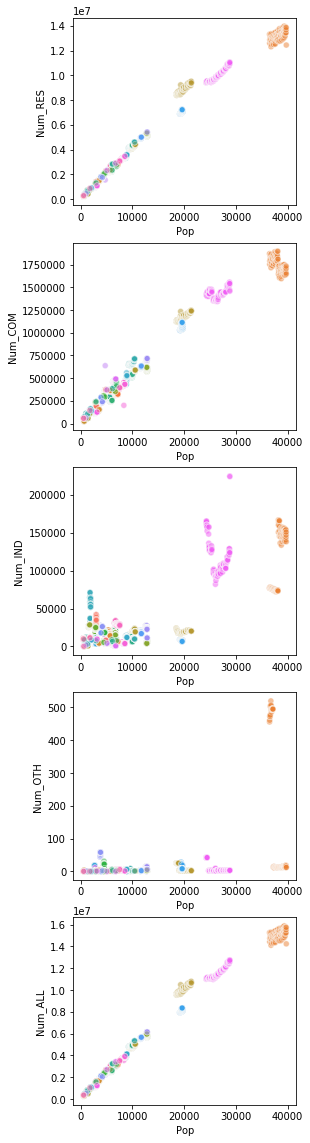

In [136]:
col = 'Pop'
# relationship with Sale_RES
to_plot = ['Num_RES', 'Num_COM', 'Num_IND','Num_OTH', 'Num_ALL']

plot_re(col,to_plot,pop_cus)

In [137]:
# GSP
gsp = pd.read_csv(cleanfolder+'gsp_all.csv')
num_gsp = gsp.merge(cus, on=['Year','Month','State'],how='left')

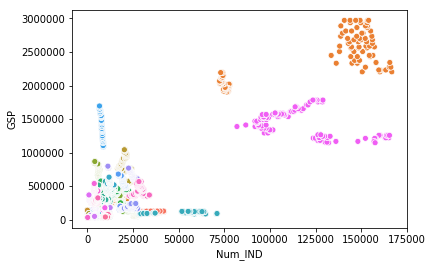

In [143]:
sns.scatterplot(data=num_gsp, x='Num_IND',y='GSP',hue='State',legend=False)

**Projecting the Num_RES**

In [144]:
pop_cus.columns

Index(['State', 'Pop', 'Year', 'Month', 'Num_RES', 'Num_COM', 'Num_IND',
       'Num_OTH', 'Num_ALL'],
      dtype='object')

In [145]:
col = 'Num_RES'
temp = pop_cus[['Pop',col]].dropna()

In [148]:
p = np.poly1d(np.polyfit(temp.Pop.values,temp[col].values,1))

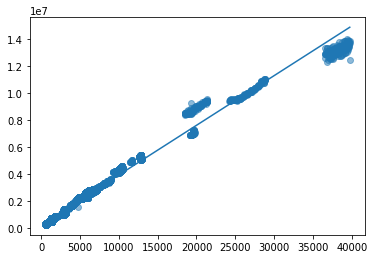

In [180]:
plt.scatter(x=temp.Pop.values,y=temp[col].values,alpha=0.5)
x = np.linspace(temp.Pop.min(), temp.Pop.max(), 100)
y = p(x)
plt.plot(x, y)

In [168]:
p(x)

array([  435869.85487,   450319.65738,   464769.45988,   479219.26239,   493669.06489,   508118.86739,
         522568.6699 ,   537018.4724 ,   551468.27491,   565918.07741,   580367.87991,   594817.68242,
         609267.48492,   623717.28742,   638167.08993,   652616.89243,   667066.69494,   681516.49744,
         695966.29994,   710416.10245,   724865.90495,   739315.70746,   753765.50996,   768215.31246,
         782665.11497,   797114.91747,   811564.71997,   826014.52248,   840464.32498,   854914.12749,
         869363.92999,   883813.73249,   898263.535  ,   912713.3375 ,   927163.14   ,   941612.94251,
         956062.74501,   970512.54752,   984962.35002,   999412.15252,  1013861.95503,  1028311.75753,
        1042761.56004,  1057211.36254,  1071661.16504,  1086110.96755,  1100560.77005,  1115010.57255,
        1129460.37506,  1143910.17756,  1158359.98007,  1172809.78257,  1187259.58507,  1201709.38758,
        1216159.19008,  1230608.99258,  1245058.79509,  1259508.59759,  1

### Price for electricity

In [544]:
sale_rev.head(2)

Year  Month State Unn_Status  RES_Revenue(1k$)  RES_Sales(MWh)  \
0  1990      1    AK      Final             17477          181752   
1  1990      1    AL      Final            123332         2070093   

   RES_Customers_count  RES_Price(c_per_kWh)  COM_Revenue(1k$)  \
0                    0                  9.62             15818   
1                    0                  5.96             54495   

   COM_Sales(MWh)  ...  TRA_Customers_count  TRA_Price(c_per_kWh)  \
0          178259  ...                    0                   0.0   
1          820415  ...                    0                   0.0   

   OTH_Revenue(1k$)  OTH_Sales(MWh)  OTH_Customers_count  \
0              1918           14816                    0   
1              2851           53954                    0   

   OTH_Price(c_per_kWh)  TOT_Revenue(1k$)  TOT_Sales(MWh)  \
0                 12.95             38848          416438   
1                  5.28            268440         5044008   

   TOT_Customers_count  TOT_Price(c_per_kWh)  
0                    0                  9.33  
1                    0                  5.32  

[2 rows x 28 columns]

In [545]:
pricecols = list(sale_rev.columns[sale_rev.columns.str.contains('Price')])
pricecols = ['Year','Month','State'] + pricecols
print(pricecols)

['Year', 'Month', 'State', 'RES_Price(c_per_kWh)', 'COM_Price(c_per_kWh)', 'IND_Price(c_per_kWh)', 'TRA_Price(c_per_kWh)', 'OTH_Price(c_per_kWh)', 'TOT_Price(c_per_kWh)']


In [546]:
priceold = sale_rev[pricecols].copy()
priceold.columns = ['Year', 'Month', 'State', 'RES', 'COM',
       'IND', 'TRA', 'OTH',
       'ALL']
priceold.sort_values(['Year','Month','State'],inplace=True)

In [547]:
# load customer data from another file
price = pd.read_csv('E:/Users/Fern/energy_data/energy/Average_retail_price_of_electricity.csv',skiprows=4)
price.head(5)

description                   units  \
0     United States : all sectors  cents per kilowatthour   
1     United States : residential  cents per kilowatthour   
2      United States : commercial  cents per kilowatthour   
3      United States : industrial  cents per kilowatthour   
4  United States : transportation  cents per kilowatthour   

            source key Jan 2001 Feb 2001 Mar 2001 Apr 2001 May 2001 Jun 2001  \
0  ELEC.PRICE.US-ALL.M     6.75     6.87     7.01     7.02     7.17     7.58   
1  ELEC.PRICE.US-RES.M     7.73     8.04     8.32     8.46     8.83     9.07   
2  ELEC.PRICE.US-COM.M     7.25     7.51      7.7     7.73     7.77     8.13   
3  ELEC.PRICE.US-IND.M     4.73      4.8     4.86     4.87        5     5.23   
4  ELEC.PRICE.US-TRA.M       --       --       --       --       --       --   

  Jul 2001  ... May 2018 Jun 2018 Jul 2018 Aug 2018 Sep 2018 Oct 2018  \
0     7.88  ...    10.41    10.79    11.03    11.02     10.7    10.46   
1     9.03  ...    13.15    13.04    13.13    13.28    13.01    12.87   
2     8.41  ...     10.5    10.82    10.98       11    10.68    10.75   
3     5.57  ...     6.82     7.18     7.34     7.21     7.09     6.91   
4       --  ...     9.46    10.16    10.19     9.69     10.3     9.84   

  Nov 2018 Dec 2018 Jan 2019 Feb 2019  
0    10.43    10.27    10.29    10.43  
1    12.95    12.47    12.47     12.7  
2    10.56    10.33    10.29    10.52  
3     6.88     6.65     6.58     6.68  
4     9.72     9.72      9.8    10.01  

[5 rows x 221 columns]

In [548]:
price = get_state_sector(price)
price_pivot = pivot_data(price)
price_pivot[(price_pivot['Year']==2019)&(price_pivot['Month']==1)].head()

Sector State    ALL    COM    IND OTH    RES    TRA  Year  Month
4641      AK  19.81  19.28  16.91   0  21.74      0  2019      1
4642      AL    9.4  11.24   5.56   0  11.85      0  2019      1
4643      AR   7.97    8.5    5.9   0    9.3  11.37  2019      1
4644      AZ   10.1    9.8   5.96   0  12.22   8.94  2019      1
4645      CA  15.66   14.9  11.43   0  18.32   8.41  2019      1

In [549]:
priceold[(priceold['Year']==2019)&(priceold['Month']==1)].head()

Year  Month State    RES    COM    IND    TRA  OTH    ALL
17748  2019      1    AK  21.74  19.28  16.91   0.00  0.0  19.81
17749  2019      1    AL  11.85  11.24   5.56   0.00  0.0   9.40
17750  2019      1    AR   9.30   8.50   5.90  11.37  0.0   7.97
17751  2019      1    AZ  12.22   9.80   5.96   8.94  0.0  10.10
17752  2019      1    CA  18.32  14.90  11.43   8.41  0.0  15.66

Data are consistence and have the same units. 

In [550]:
priceall = concat_replace(priceold,price_pivot)

In [551]:
priceall.head()

Year  Month State   RES   COM   IND    OTH   ALL
0  1990      1    AK  9.62  8.87  8.74  12.95  9.33
1  1990      1    AL  5.96  6.64  4.18   5.28  5.32
2  1990      1    AR  7.06  6.52  4.73   6.55  6.16
3  1990      1    AZ  7.83  7.64  5.34   5.19  7.07
4  1990      1    CA  9.68  8.46  6.03   3.69  8.04

In [552]:
priceall.tail()

Year  Month State    RES    COM    IND     OTH    ALL
3718  2019      2    VT  16.67  16.07  10.97      00  15.18
3719  2019      2    WA    9.4   8.69   5.23    09.6   8.26
3720  2019      2    WI  14.15  10.95   7.83  012.85  11.04
3721  2019      2    WV   9.98   9.36    6.1      00   8.31
3722  2019      2    WY  10.61   9.53   6.97      00   8.25

In [554]:
priceall.to_csv('E:/Users/Fern/energy_data/clean/price.csv',index=False)

In [556]:
priceall = pd.read_csv('E:/Users/Fern/energy_data/clean/price.csv')

In [557]:
priceall.shape

(17850, 8)

In [558]:
priceall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17850 entries, 0 to 17849
Data columns (total 8 columns):
Year     17850 non-null int64
Month    17850 non-null int64
State    17850 non-null object
RES      17850 non-null float64
COM      17850 non-null float64
IND      17850 non-null float64
OTH      17850 non-null float64
ALL      17850 non-null float64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.1+ MB


# Population data

We want to get a monthly the population data for each state, which does not exist. Fortunately, St. Louis FRED Economic Data provide some estimation based on Census data. From projection of US monthly population, use annual population by state to calculate the monthly population by state. 

In [630]:
# files for all state population
state_files = glob('E:/Users/Fern/energy_data/population_USA/state_pop/*.csv')
# file for total US population
us_pop = pd.read_csv('E:/Users/Fern/energy_data/population_USA/POP-usa-THM.csv')

In [587]:
us_pop.head()

DATE    POPTHM
0  1959-01-01  175818.0
1  1959-02-01  176044.0
2  1959-03-01  176274.0
3  1959-04-01  176503.0
4  1959-05-01  176723.0

In [563]:
# look at one state 
state1 = pd.read_csv(state_files[0])
state1.head()

DATE  AKPOP
0  1950-01-01  135.0
1  1951-01-01  158.0
2  1952-01-01  189.0
3  1953-01-01  205.0
4  1954-01-01  215.0

In [631]:
# assemple all state pop into one df 
state_pop = pd.DataFrame(columns=['DATE'])
for file in state_files:
    state_pop = state_pop.merge(pd.read_csv(file),on='DATE', how='outer')

In [571]:
state_pop.head()

DATE  AKPOP   ALPOP   ARPOP  AZPOP    CAPOP   COPOP   CTPOP  DCPOP  \
0  1950-01-01  135.0  3058.0  1908.0  756.0  10677.0  1325.0  2016.0  806.0   
1  1951-01-01  158.0  3059.0  1901.0  785.0  11134.0  1326.0  2028.0  808.0   
2  1952-01-01  189.0  3068.0  1838.0  842.0  11635.0  1365.0  2081.0  805.0   
3  1953-01-01  205.0  3053.0  1780.0  894.0  12251.0  1431.0  2168.0  810.0   
4  1954-01-01  215.0  3014.0  1734.0  933.0  12746.0  1493.0  2249.0  791.0   

   DEPOP  ...  SDPOP   TNPOP   TXPOP  UTPOP   VAPOP  VTPOP   WAPOP   WIPOP  \
0  321.0  ...  655.0  3315.0  7776.0  696.0  3315.0  379.0  2387.0  3438.0   
1  331.0  ...  655.0  3372.0  8111.0  706.0  3434.0  378.0  2424.0  3439.0   
2  341.0  ...  651.0  3352.0  8314.0  724.0  3504.0  375.0  2448.0  3469.0   
3  351.0  ...  648.0  3319.0  8336.0  739.0  3557.0  379.0  2466.0  3506.0   
4  368.0  ...  655.0  3359.0  8382.0  750.0  3555.0  377.0  2516.0  3608.0   

    WVPOP  WYPOP  
0  2006.0  290.0  
1  1984.0  291.0  
2  1957.0  293.0  
3  1929.0  290.0  
4  1905.0  293.0  

[5 rows x 52 columns]

In [573]:
state_pop.columns = state_pop.columns.str.replace('POP','')
state_pop.columns

Index(['DATE', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object')

In [632]:
state_pop['SUM'] = state_pop.sum(axis=1)

In [639]:
state_pop['DATE'] = pd.to_datetime(state_pop['DATE'])
state_pop.sort_values('DATE',inplace=True)

In [586]:
 state_pop.tail()

DATE       AK        AL        AR        AZ         CA        CO  \
64 2014-01-01  736.307  4842.481  2967.726  6733.840  38625.139  5351.218   
65 2015-01-01  737.547  4853.160  2978.407  6833.596  38953.142  5452.107   
66 2016-01-01  741.504  4864.745  2990.410  6945.452  39209.127  5540.921   
67 2017-01-01  739.786  4875.120  3002.997  7048.876  39399.349  5615.902   
68 2018-01-01  737.438  4887.871  3013.825  7171.646  39557.045  5695.564   

          CT       DC       DE  ...        TN         TX        UT        VA  \
64  3594.783  662.513  932.596  ...  6540.826  26977.142  2937.399  8312.076   
65  3587.509  675.254  941.413  ...  6590.808  27486.814  2982.497  8362.907   
66  3578.674  686.575  949.216  ...  6645.011  27937.492  3042.613  8410.946   
67  3573.880  695.691  957.078  ...  6708.794  28322.717  3103.118  8465.207   
68  3572.665  702.455  967.171  ...  6770.010  28701.845  3161.105  8517.685   

         VT        WA        WI        WV       WY         SUM  
64  625.218  7052.439  5751.974  1849.467  582.548  318386.421  
65  625.197  7163.543  5761.406  1841.996  585.668  320742.673  
66  623.644  7294.680  5772.958  1830.929  584.290  323071.342  
67  624.525  7425.432  5792.051  1817.048  578.934  325147.121  
68  626.299  7535.591  5813.568  1805.832  577.737  327167.434  

[5 rows x 53 columns]

Check data consistency with us_pop

In [636]:
us_pop['DATE'] = pd.to_datetime(us_pop['DATE'])

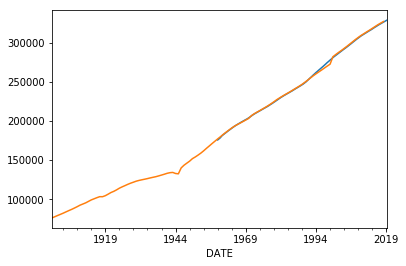

In [641]:
us_pop.set_index('DATE')['POPTHM'].plot()
state_pop.set_index('DATE')['SUM'].plot()

Generate percent population

In [651]:
state_popper = state_pop.drop('SUM',axis=1).copy()

for col in state_popper.columns[1:]:
    state_popper[col] = state_pop[col]/state_pop['SUM']

In [652]:
state_popper = us_pop.merge(state_popper, on='DATE',how='left')

In [668]:
state_popper = state_popper.fillna(method='ffill')
state_popper.tail()

DATE    POPTHM     AKPOP    ALPOP     ARPOP    AZPOP     CAPOP  \
718 2018-11-01  328241.0  0.002254  0.01494  0.009212  0.02192  0.120908   
719 2018-12-01  328393.0  0.002254  0.01494  0.009212  0.02192  0.120908   
720 2019-01-01  328539.0  0.002254  0.01494  0.009212  0.02192  0.120908   
721 2019-02-01  328677.0  0.002254  0.01494  0.009212  0.02192  0.120908   
722 2019-03-01  328817.0  0.002254  0.01494  0.009212  0.02192  0.120908   

        COPOP    CTPOP     DCPOP  ...     SDPOP     TNPOP     TXPOP     UTPOP  \
718  0.017409  0.01092  0.002147  ...  0.002697  0.020693  0.087728  0.009662   
719  0.017409  0.01092  0.002147  ...  0.002697  0.020693  0.087728  0.009662   
720  0.017409  0.01092  0.002147  ...  0.002697  0.020693  0.087728  0.009662   
721  0.017409  0.01092  0.002147  ...  0.002697  0.020693  0.087728  0.009662   
722  0.017409  0.01092  0.002147  ...  0.002697  0.020693  0.087728  0.009662   

        VAPOP     VTPOP     WAPOP     WIPOP    WVPOP     WYPOP  
718  0.026035  0.001914  0.023033  0.017769  0.00552  0.001766  
719  0.026035  0.001914  0.023033  0.017769  0.00552  0.001766  
720  0.026035  0.001914  0.023033  0.017769  0.00552  0.001766  
721  0.026035  0.001914  0.023033  0.017769  0.00552  0.001766  
722  0.026035  0.001914  0.023033  0.017769  0.00552  0.001766  

[5 rows x 53 columns]

In [675]:
state_popmonth = state_popper.copy()
for col in state_popper.columns[2:]:
    state_popmonth[col] = (state_popper[col]*state_popper['POPTHM']).round(3)

state_popmonth.drop('POPTHM', axis=1,inplace=True)
state_popmonth.columns = state_popmonth.columns.str.replace('POP','')


In [676]:
state_popmonth.tail()

DATE       AK        AL        AR        AZ         CA        CO  \
718 2018-11-01  739.858  4903.910  3023.715  7195.179  39686.847  5714.253   
719 2018-12-01  740.200  4906.181  3025.115  7198.511  39705.225  5716.900   
720 2019-01-01  740.530  4908.362  3026.460  7201.711  39722.878  5719.441   
721 2019-02-01  740.841  4910.424  3027.731  7204.736  39739.563  5721.844   
722 2019-03-01  741.156  4912.515  3029.021  7207.805  39756.490  5724.281   

           CT       DC       DE  ...       SD        TN         TX        UT  \
718  3584.388  704.760  970.345  ...  885.130  6792.225  28796.027  3171.478   
719  3586.048  705.086  970.794  ...  885.540  6795.370  28809.362  3172.946   
720  3587.642  705.400  971.226  ...  885.934  6798.392  28822.170  3174.357   
721  3589.149  705.696  971.634  ...  886.306  6801.247  28834.277  3175.690   
722  3590.678  705.997  972.047  ...  886.683  6804.144  28846.559  3177.043   

           VA       VT        WA        WI        WV       WY  
718  8545.635  628.354  7560.318  5832.645  1811.758  579.633  
719  8549.592  628.645  7563.819  5835.346  1812.597  579.901  
720  8553.393  628.925  7567.182  5837.940  1813.402  580.159  
721  8556.986  629.189  7570.361  5840.392  1814.164  580.403  
722  8560.631  629.457  7573.585  5842.880  1814.937  580.650  

[5 rows x 52 columns]

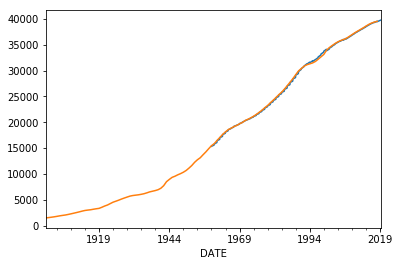

In [679]:
# check if procedure was correct 
state_popmonth.set_index('DATE')['CA'].plot()
state_pop.set_index('DATE')['CAPOP'].plot()

In [685]:
state_pivot = pd.melt(state_popmonth,id_vars=['DATE'],var_name='State', value_name='Pop')
state_pivot['Year'] = state_pivot['DATE'].dt.year
state_pivot['Month'] = state_pivot['DATE'].dt.month
state_pivot.sort_values(['Year','Month','State'],inplace=True)

In [686]:
state_pivot.head()

DATE State        Pop  Year  Month
0    1959-01-01    AK    222.333  1959      1
723  1959-01-01    AL   3180.160  1959      1
1446 1959-01-01    AR   1742.934  1959      1
2169 1959-01-01    AZ   1251.617  1959      1
2892 1959-01-01    CA  15351.916  1959      1

In [687]:
state_pivot.drop('DATE',axis=1).to_csv('E:/Users/Fern/energy_data/clean/state_pop.csv',index=False)

In [2]:
state_pop = pd.read_csv('E:/Users/Fern/energy_data/clean/state_pop.csv')

In [3]:
state_pop.head()

State        Pop  Year  Month
0    AK    222.333  1959      1
1    AL   3180.160  1959      1
2    AR   1742.934  1959      1
3    AZ   1251.617  1959      1
4    CA  15351.916  1959      1

Remove data before 1989

In [5]:
state_pop = state_pop[state_pop['Year']>=1989]
state_pop.to_csv('E:/Users/Fern/energy_data/clean/state_pop.csv',index=False)

# Temperature by State  

Monthly from ftp://ftp.ncdc.noaa.gov/pub/data/cirs/climdiv/

I am interested in how temperature and climate effect the electricity use.

Details about the data:

- monthly maximum, minimum and average temperature (deg. F. to 10ths, 
national temperature to 100ths), precipitation (inches to 100ths), 
Standardized Precipitation Index (SPI), and Palmer Drought Indices (PDSI, 
PHDI, PMDI, and ZNDX). Most importanting: heating and cooling degree days, which are number of days with temperature higher or below certain degree and thus heating or air conditioning are required. 

The first three letters are STATE CODE, which stored in state_code.csv:
4 is division number (0 means average over regions)
The 5-6 codes are data type code
7 - 10 are years 

each columns are monthly data starting in Jan 

For example:
001 0 26 1895 mean region 001, cooling degree days in 1895 


In [841]:
# load code maps 
data_code = pd.read_csv(mfolder+'state_temp/data_code.csv',header=None,index_col=0).to_dict()[1]
# load code maps 
state_code = pd.read_csv(mfolder+'state_temp/state_code.csv',header=None,index_col=0,sep='\t').to_dict()[1]

In [816]:
state_code[8]

'Florida'

In [862]:
#load data files
t_files = glob(mfolder+'state_temp/clim*')[:2]
t_files 

['E:/Users/Fern/energy_data/state_temp\\climdiv-cddcst-v1.0.0-20190408',
 'E:/Users/Fern/energy_data/state_temp\\climdiv-hddcst-v1.0.0-20190408']

In [962]:
def clean_clim(file):
    ''' input filename, load the data, replace missing data, extract year
    look up the state code, data code  
    ''' 
    # load data file, remove left white space and split by white space into columns
    df = pd.read_csv(file,header=None).iloc[:,0].str.lstrip().str.split(expand=True)
    #clean up -9999., which mean null 
    df = df.replace('-9999.',np.nan)
    # extract state code 
    df['State_code'] = df.iloc[:,0].str[:3].astype(int)
    # extract data code 
    df['Data_code'] = df.iloc[:,0].str[4:6].astype(int)
    # extract year 
    df['Year'] = df.iloc[:,0].str[6:].astype(int)
    # drop State_code higher than 50 to keep only state data
    df = df[df['State_code'] <=50]
    
    #look up state code
    df['State'] = [state_code[int(code)] for code in df['State_code'].values]
    df['State'] = [us_state_abbrev[name] for name in df['State'].values]
    #look up data code
    df['data'] = [data_code[int(code)] for code in df['Data_code'].values ]
    
    return df

In [963]:
def add_dc(df):
    # add dc data using Maryland's data 
    temp = df[df['State'] =='MD'].copy()
    temp['State'] = 'DC'
    df = pd.concat([df,temp])
    return df

In [964]:
colddays = clean_clim(t_files[0])
# no data from alaska 
colddays = colddays[colddays['State']!='AK']
# add dc data
colddays = add_dc(colddays)

In [965]:
#drop old columns
colddays = colddays.drop([0,'State_code','Data_code'],axis=1)

In [969]:
# reshape df
colddays_melt = colddays.melt(id_vars=['Year','State','data'],var_name='Month',value_name='Cooling_deg_days')
colddays_melt = colddays_melt.drop('data',axis=1)
colddays_melt = colddays_melt.dropna()
colddays_melt['Cooling_deg_days'] = colddays_melt['Cooling_deg_days'].str.replace('.','').astype(int)

In [970]:
colddays_melt.head()

Year State Month  Cooling_deg_days
0  1895    AL     1                 5
1  1896    AL     1                 4
2  1897    AL     1                 4
3  1898    AL     1                19
4  1899    AL     1                 5

Hot day data

In [971]:
hotdays = clean_clim(t_files[1])
# no data from alaska 
hotdays = hotdays[hotdays['State']!='AK']
# add dc data
hotdays = add_dc(hotdays)
#drop old columns
hotdays = hotdays.drop([0,'State_code','Data_code'],axis=1)
# reshape df
hotdays_melt = hotdays.melt(id_vars=['Year','State','data'],var_name='Month',value_name='Heating_deg_days')
hotdays_melt = hotdays_melt.drop('data',axis=1)
hotdays_melt = hotdays_melt.dropna()
hotdays_melt['Heating_deg_days'] = hotdays_melt['Heating_deg_days'].str.replace('.','').astype(int)

In [972]:
hotdays_melt.head()

Year State Month  Heating_deg_days
0  1895    AL     1               716
1  1896    AL     1               692
2  1897    AL     1               751
3  1898    AL     1               544
4  1899    AL     1               689

In [974]:
cold_hot_days = hotdays_melt.merge(colddays_melt,on=['Year','State','Month'])
cold_hot_days.head()

Year State Month  Heating_deg_days  Cooling_deg_days
0  1895    AL     1               716                 5
1  1896    AL     1               692                 4
2  1897    AL     1               751                 4
3  1898    AL     1               544                19
4  1899    AL     1               689                 5

In [975]:
cold_hot_days.to_csv(cleanfolder+'cold_hot_days.csv',index=False) 

In [9]:
cold_hot_days = pd.read_csv(cleanfolder+'cold_hot_days.csv')
# drop data before 1989 
cold_hot_days[cold_hot_days['Year']>=1989].to_csv(cleanfolder+'cold_hot_days.csv',index=False) 

# Unemployment by state

Montly unemployment by state 

In [724]:
urfiles = glob('E:/Users\Fern/energy_data/umemployment/*.csv')
ex = pd.read_csv(urfiles[0])

In [725]:
ex.head()

DATE  AKUR
0  1976-01-01   7.1
1  1976-02-01   7.1
2  1976-03-01   7.0
3  1976-04-01   7.0
4  1976-05-01   7.0

In [726]:
def proc_ur(df):
    '''Take in the raw_unemployment data 
    extrac year, month and state output df with year, month, State ID and unemployment data'''
    
    state_id = df.columns[1][:2]
    df.columns = ['DATE','UR']
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['Year'] = df['DATE'].dt.year
    df['Month'] = df['DATE'].dt.month
    df['State'] = state_id
    
    return df.drop('DATE',axis=1)

In [729]:
urall = pd.DataFrame()
for file in urfiles:
    state_ur = proc_ur(pd.read_csv(file))
    urall = pd.concat([urall,state_ur])

urall = urall.sort_values(['Year','Month','State'])

In [731]:
urall.tail()

UR  Year  Month State
518  2.3  2019      3    VT
518  4.6  2019      3    WA
518  2.9  2019      3    WI
518  5.1  2019      3    WV
518  3.7  2019      3    WY

In [732]:
cleanfolder = 'E:/Users/Fern/energy_data/clean/'

In [733]:
urall.to_csv(cleanfolder+'unemploy.csv',index=False)

In [10]:
urall = pd.read_csv(cleanfolder+'unemploy.csv')
urall[urall['Year']>=1989].to_csv(cleanfolder+'unemploy.csv',index=False)

# Personal income by state

quarterly income by state (million dollar)


In [741]:
income_files = glob(mfolder+'personal_income/*.csv')
inc = pd.read_csv(income_files[0])

In [738]:
inc.head()

DATE  AKOTOT
0  1950-01-01   343.4
1  1950-04-01   373.8
2  1950-07-01   408.5
3  1950-10-01   439.8
4  1951-01-01   470.5

In [749]:
def proc_in(df):
    '''Take in the raw_income data 
    extrac year, month and state output df with year, month, State ID and income data'''
    
    state_id = df.columns[1][:2]
    df.columns = ['DATE','Income']
    # change date column to datetime data 
    df['DATE'] = pd.to_datetime(df['DATE'])
    # set as index
    df = df.set_index('DATE')    
    #resample to get montly data
    df = df['Income'].resample('1M').bfill()
    #reset index 
    df = df.reset_index()
    # extract year and month 
    df['Year'] = df['DATE'].dt.year
    df['Month'] = df['DATE'].dt.month
    df['State'] = state_id
    
    return df.drop('DATE',axis=1)

In [750]:
inall = pd.DataFrame()
for file in income_files:
    state_in = proc_in(pd.read_csv(file))
    inall = pd.concat([inall,state_in])

inall = inall.sort_values(['Year','Month','State'])
inall.head()

Income  Year  Month State
0   2595.6  1948      1    AL
0   1645.4  1948      1    AR
0    919.4  1948      1    AZ
0  18093.5  1948      1    CA
0   1861.0  1948      1    CO

In [752]:
inall.to_csv(cleanfolder+'totalincome.csv',index=False)

In [11]:
inall = pd.read_csv(cleanfolder+'totalincome.csv')
inall[inall['Year']>=1989].to_csv(cleanfolder+'totalincome.csv',index=False)

#  Consumer price index USA


In [754]:
cpi = pd.read_csv(mfolder+'consumer-price_index_CPILFENS.csv')
cpi.head()

DATE  CPILFENS
0  1957-01-01      28.5
1  1957-02-01      28.5
2  1957-03-01      28.7
3  1957-04-01      28.8
4  1957-05-01      28.8

In [755]:
cpi.columns = ['DATE','CPI']
cpi['DATE'] = pd.to_datetime(cpi['DATE'])
cpi['Year'] = cpi['DATE'].dt.year
cpi['Month'] = cpi['DATE'].dt.month


In [756]:
cpi.drop('DATE',axis=1).to_csv(cleanfolder+'consumer_price_idx.csv',index=False)

# GDP per state (GSP)

In [4]:
bea_files = glob(mfolder+'GDP_BEA/*.csv')
gsp1 = pd.read_csv(bea_files[0])
gsp1 = gsp1[gsp1['CODE']==1]
gsp1.head(2)

ID                                          COMPONENT  FIPS   REGION  \
0   200  Gross Domestic Product by State (millions of c...   1.0  Alabama   
81  200  Gross Domestic Product by State (millions of c...   2.0   Alaska   

    CODE            INDUSTRY    1997    1998    1999    2000    2001    2002  \
0    1.0  All industry total  101808  106459  112041  116014  120112  125138   
81   1.0  All industry total   25171   23312   23866   25913   27747   28887   

      2003    2004    2005    2006    2007    2008    2009  
0   130835  142086  151096  159263  166217  171748  169856  
81   30905   34408   37824   41820   44288   48551   45709

In [5]:
gsp2 = pd.read_csv(bea_files[1])
gsp2.columns = gsp2.columns.str.strip()
gsp2 =  gsp2[gsp2['CODE']==0]

# gsp2 columns has extra space, need to remove it before
for col in gsp2.columns:
    if gsp2[col].dtype=='O':
        gsp2[col]=gsp2[col].str.strip()

gsp2.head(2)

ID                                          COMPONENT  FIPS   REGION  \
0   200  Gross State Product (millions of current dollars)   1.0  Alabama   
78  200  Gross State Product (millions of current dollars)   2.0   Alaska   

    CODE                   INDUSTRY   1977   1978   1979   1980  ...   1988  \
0    0.0  Total Gross State Product  26546  30377  33535  36006  ...  65435   
78   0.0  Total Gross State Product   7492   9088  10863  15138  ...  21307   

     1989   1990   1991   1992   1993   1994   1995   1996    1997  
0   67875  71085  75293  80450  83453  88581  94021  97941  102533  
78  23357  24987  22164  22591  22965  23110  24805  26083   26884  

[2 rows x 27 columns]

In [6]:
def proc_gsp(gsp):
    
    gsp = gsp[gsp['REGION'].isin([*us_state_abbrev])].copy()
    gsp['State'] = [us_state_abbrev[code] for code in gsp['REGION'] ]
    gsp = gsp.drop(['ID', 'COMPONENT', 'FIPS', 'CODE','INDUSTRY','REGION'],axis=1)
    
    return gsp    

In [7]:
gsp1 = proc_gsp(gsp1).sort_values('State').set_index('State')
gsp2 = proc_gsp(gsp2).sort_values('State').set_index('State')

In [11]:
gsp_bea = gsp1.merge(gsp2.drop('1997',axis=1),left_index=True, right_index=True,how='outer').reset_index()

In [12]:
gsp_bea.head()

State          1997         1998          1999          2000          2001  \
0    AK         25171        23312         23866         25913         27747   
1    AL        101808       106459        112041        116014        120112   
2    AR         59837        61765         66091         68146         70925   
3    AZ        128099       139289        151188        161901        170174   
4    CA  1.03785e+006  1.1128e+006  1.21022e+006  1.31734e+006  1.33805e+006   

           2002         2003         2004          2005  ...    1987    1988  \
0         28887        30905        34408         37824  ...   22258   21307   
1        125138       130835       142086        151096  ...   60586   65435   
2         73953        77767        83551         88227  ...   32190   34508   
3        177106       189139       201287        222968  ...   59171   63639   
4  1.38575e+006  1.4603e+006  1.5712e+006  1.69199e+006  ...  620177  678774   

     1989    1990    1991    1992    1993    1994    1995    1996  
0   23357   24987   22164   22591   22965   23110   24805   26083  
1   67875   71085   75293   80450   83453   88581   94021   97941  
2   36647   38109   40950   44312   46599   50179   53303   56455  
3   66390   69322   72263   79695   85157   95292  104036  113138  
4  734406  788322  801193  819389  833656  862481  908963  958476  

[5 rows x 34 columns]

In [14]:
gsp_bea['State'].unique().shape

(51,)

In [15]:
gsp_bea_all = gsp_bea.melt(id_vars=['State'],var_name='Year', value_name='GSP').sort_values(['Year','State'])

In [16]:
gsp_bea_all['Year'].unique()

array(['1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009'], dtype=object)

In [17]:
gsp_bea_all['Year'] = gsp_bea_all['Year'].astype(int)
# keep only 1989 to 2004 
gsp_bea_all = gsp_bea_all[gsp_bea_all['Year']<=2004]
gsp_bea_all = gsp_bea_all[gsp_bea_all['Year']>=1989]

In [18]:
gsp_bea_all['Year'] = pd.to_datetime(gsp_bea_all['Year'],format='%Y')

In [19]:
gsp_bea_all.columns = ['State','DATE','GSP'] 

GSP from St.Louis Fed 

In [20]:
#quarter files from 2005 to 2018
gspq_fed_files = glob(mfolder+'GDP_stlouisfed/*NQGSP.csv')

In [21]:
def proc_gsp(file):
    df = pd.read_csv(file)
    df.columns = ['DATE', df.columns[1][:2]]
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.melt(id_vars=['DATE'],var_name='State', value_name='GSP').sort_values(['DATE','State'])
    return df

In [22]:
gsp_all = pd.DataFrame()
for file in gspq_fed_files:
    gsp_all = pd.concat([gsp_all,proc_gsp(file)])
    

In [23]:
gsp = pd.concat([gsp_bea_all, gsp_all],sort=True)

In [24]:
gsp.head()

DATE     GSP State
1275 1989-01-01   23357    AK
1276 1989-01-01   67875    AL
1277 1989-01-01   36647    AR
1278 1989-01-01   66390    AZ
1279 1989-01-01  734406    CA

In [25]:
gsp.tail()

DATE      GSP State
50 2017-07-01  37978.9    WY
51 2017-10-01  39110.8    WY
52 2018-01-01  39503.1    WY
53 2018-04-01  40384.2    WY
54 2018-07-01  40994.6    WY

In [26]:
def resample_bystate(state):
    temp = gsp[gsp['State']==state]
    row =  pd.DataFrame.from_dict({'DATE':['2018-12-01'],
                                   'GSP':[temp.iloc[-1,1]],
                                   'State':[state]})
    row['DATE'] = pd.to_datetime(row['DATE'])
    temp = pd.concat([temp,row]).set_index('DATE')
    temp = temp.resample('1M').ffill()
    temp.head()
    
    return temp  

In [27]:
gsp_resam = pd.DataFrame()
for state in gsp['State'].unique():
    gsp_resam = pd.concat([gsp_resam,resample_bystate(state)])

In [28]:
gsp_resam = gsp_resam.reset_index()
gsp_resam['Year']=gsp_resam['DATE'].dt.year
gsp_resam['Month']=gsp_resam['DATE'].dt.month
gsp_resam.head()

DATE    GSP State  Year  Month
0 1989-01-31  23357    AK  1989      1
1 1989-02-28  23357    AK  1989      2
2 1989-03-31  23357    AK  1989      3
3 1989-04-30  23357    AK  1989      4
4 1989-05-31  23357    AK  1989      5

In [32]:
gsp_resam[(gsp_resam['State']=='DC')&(gsp_resam['Year']== 1997)]

DATE    GSP State  Year  Month
2616 1997-01-31  50259    DC  1997      1
2617 1997-02-28  50259    DC  1997      2
2618 1997-03-31  50259    DC  1997      3
2619 1997-04-30  50259    DC  1997      4
2620 1997-05-31  50259    DC  1997      5
2621 1997-06-30  50259    DC  1997      6
2622 1997-07-31  50259    DC  1997      7
2623 1997-08-31  50259    DC  1997      8
2624 1997-09-30  50259    DC  1997      9
2625 1997-10-31  50259    DC  1997     10
2626 1997-11-30  50259    DC  1997     11
2627 1997-12-31  50259    DC  1997     12

In [33]:
gsp_resam.drop(['DATE'],axis=1).to_csv(cleanfolder+'gsp_all.csv',index=False)

# Combine all data 

In [34]:
# obtain electricity data sale, numer of customer, price and revenue 
sale = pd.read_csv(cleanfolder+'sale.csv',sep='\t')
num_cus = pd.read_csv(cleanfolder+'customer.csv',sep='\t')
price = num_cus = pd.read_csv(cleanfolder+'price.csv',sep='\t')
rev= num_cus = pd.read_csv(cleanfolder+'revenue.csv',sep='\t')

In [35]:
#load number of hot cold day
ch_days = pd.read_csv(cleanfolder+'cold_hot_days.csv')
# load consumer price index (exclude food and energy)
cpi = pd.read_csv(cleanfolder+'consumer_price_idx.csv')
# state population
pop = pd.read_csv(cleanfolder+'state_pop.csv')
# total income by state 
income = pd.read_csv(cleanfolder+'totalincome.csv')
# unemployment by state 
unem = pd.read_csv(cleanfolder+'unemploy.csv')
# GSP
gsp = pd.read_csv(cleanfolder+'gsp_all.csv')

In [36]:
# comebine all data 
combine = sale.merge(price, on=['Year','Month','State'],how='left')
combine = combine.merge(rev, on=['Year','Month','State'],how='left')
combine = combine.merge(ch_days, on=['Year','Month','State'],how='left')
combine = combine.merge(pop, on = ['Year','Month','State'],how='left')
combine = combine.merge(income, on = ['Year','Month','State'],how='left')
combine = combine.merge(unem, on = ['Year','Month','State'],how='left')
combine = combine.merge(gsp, on = ['Year','Month','State'],how='left')
combine = combine.merge(cpi, on=['Year','Month'],how='left')

In [37]:
combine['Year-Month'] = combine['Year'].astype(str) + combine['Month'].astype(str)
combine['Year-Month'] = pd.to_datetime(combine['Year-Month'],format='%Y%m')

In [38]:
combine.head()

Year  Month State  Sale_RES  Sale_COM  Sale_IND  Sale_OTH  Sale_ALL  \
0  1990      1    AK    181.75    178.26     41.61     14.82    416.44   
1  1990      1    AL   2070.09    820.42   2099.55     53.95   5044.01   
2  1990      1    AR   1026.32    474.99    782.49     47.60   2331.40   
3  1990      1    AZ   1396.50   1081.79    809.80    151.06   3439.15   
4  1990      1    CA   6168.01   6011.77   4454.66    869.56  17504.01   

   Price_RES  Price_COM  ...  Rev_OTH  Rev_ALL  Heating_deg_days  \
0       9.62       8.87  ...     1.92    38.85               NaN   
1       5.96       6.64  ...     2.85   268.44             517.0   
2       7.06       6.52  ...     3.12   143.64             620.0   
3       7.83       7.64  ...     7.83   243.13             523.0   
4       9.68       8.46  ...    32.10  1406.54             552.0   

   Cooling_deg_days        Pop    Income   UR       GSP    CPI  Year-Month  
0               NaN    551.520   12776.9  7.2   24987.0  132.0  1990-01-01  
1              21.0   4036.801   64029.4  6.7   71085.0  132.0  1990-01-01  
2               5.0   2347.535   34283.2  6.7   38109.0  132.0  1990-01-01  
3               0.0   3668.417   63546.7  5.2   69322.0  132.0  1990-01-01  
4               0.0  29863.502  640724.9  5.2  788322.0  132.0  1990-01-01  

[5 rows x 26 columns]

In [40]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17850 entries, 0 to 17849
Data columns (total 26 columns):
Year                17850 non-null int64
Month               17850 non-null int64
State               17850 non-null object
Sale_RES            17850 non-null float64
Sale_COM            17850 non-null float64
Sale_IND            17850 non-null float64
Sale_OTH            17850 non-null float64
Sale_ALL            17850 non-null float64
Price_RES           17850 non-null float64
Price_COM           17850 non-null float64
Price_IND           17850 non-null float64
Price_OTH           17850 non-null float64
Price_ALL           17850 non-null float64
Rev_RES             17850 non-null float64
Rev_COM             17850 non-null float64
Rev_IND             17850 non-null float64
Rev_OTH             17850 non-null float64
Rev_ALL             17850 non-null float64
Heating_deg_days    17150 non-null float64
Cooling_deg_days    17150 non-null float64
Pop                 17850 non-null f

 - missing data for coolig and heating days for AK
 - missing early 1990 GSP data for DC 
 - Missing 2019 income and GSP data 

In [41]:
# find all the null values 
combine[combine.isnull().any(axis=1)]

Year  Month State  Sale_RES  Sale_COM  Sale_IND  Sale_OTH  Sale_ALL  \
0      1990      1    AK    181.75    178.26     41.61     14.82    416.44   
7      1990      1    DC    168.77    447.25    237.96     29.48    883.46   
11     1990      1    HI    206.58    168.39    290.73      4.82    670.52   
51     1990      2    AK    177.50    174.40     39.44     17.18    408.52   
58     1990      2    DC    120.48    399.53    224.48     25.78    770.27   
62     1990      2    HI    179.00    157.23    268.10      4.65    608.98   
102    1990      3    AK    161.48    170.43     37.46     12.81    382.19   
109    1990      3    DC    120.96    396.20    227.04     25.38    769.58   
113    1990      3    HI    204.60    174.70    297.37      4.87    681.54   
153    1990      4    AK    130.37    154.70     44.68     14.23    343.97   
160    1990      4    DC    105.25    366.30    217.14     25.50    714.19   
164    1990      4    HI    188.15    176.85    305.42      5.01    675.43   
204    1990      5    AK    113.74    154.22     44.23     12.48    324.67   
211    1990      5    DC     92.46    381.85    237.69     24.58    736.58   
215    1990      5    HI    188.59    186.55    319.94      4.67    699.74   
255    1990      6    AK    105.54    149.59     35.65     11.24    302.02   
262    1990      6    DC     97.10    421.06    265.05     24.77    807.97   
266    1990      6    HI    182.83    180.05    321.49      4.77    689.14   
306    1990      7    AK    104.42    156.75     40.62      9.89    311.68   
313    1990      7    DC    147.18    496.19    303.94     27.65    974.96   
317    1990      7    HI    193.00    188.16    331.98      5.02    718.16   
357    1990      8    AK    112.00    156.93     38.25     11.31    318.49   
364    1990      8    DC    159.09    476.95    280.35     26.10    942.49   
368    1990      8    HI    198.50    199.73    337.65      4.90    740.78   
408    1990      9    AK    109.26    155.10     33.19     11.66    309.22   
415    1990      9    DC    141.48    481.41    281.46     26.79    931.14   
419    1990      9    HI    192.18    194.51    320.42      4.96    712.07   
459    1990     10    AK    126.50    161.10     33.51     13.68    334.78   
466    1990     10    DC    109.23    426.27    251.44     26.86    813.80   
470    1990     10    HI    197.25    201.18    327.15      4.92    730.50   
...     ...    ...   ...       ...       ...       ...       ...       ...   
17820  2019      2    ME    465.00    327.00    140.00      0.00    932.00   
17821  2019      2    MI   2786.00   2869.00   2230.00      1.00   7886.00   
17822  2019      2    MN   2030.00   1762.00   1555.00      3.00   5350.00   
17823  2019      2    MO   3264.00   2445.00    849.00      2.00   6561.00   
17824  2019      2    MS   1473.00    982.00   1290.00      0.00   3746.00   
17825  2019      2    MT    561.00    442.00    394.00      0.00   1397.00   
17826  2019      2    NC   4766.00   3474.00   1918.00      2.00  10159.00   
17827  2019      2    ND    605.00    599.00    710.00      0.00   1914.00   
17828  2019      2    NE   1003.00    802.00    728.00      0.00   2534.00   
17829  2019      2    NH    398.00    337.00    150.00      0.00    885.00   
17830  2019      2    NJ   2089.00   2912.00    529.00     28.00   5558.00   
17831  2019      2    NM    526.00    674.00    628.00      0.00   1829.00   
17832  2019      2    NV    867.00    806.00    874.00      1.00   2548.00   
17833  2019      2    NY   4193.00   6225.00   1368.00    260.00  12045.00   
17834  2019      2    OH   4584.00   3509.00   3613.00      4.00  11711.00   
17835  2019      2    OK   1889.00   1446.00   1461.00      0.00   4795.00   
17836  2019      2    OR   2007.00   1398.00    884.00      2.00   4291.00   
17837  2019      2    PA   5299.00   3485.00   3868.00     63.00  12715.00   
17838  2019      2    RI    238.00    276.00     45.00      2.00    562.00   
17839  2019      2    SC   23

In [44]:
combine.to_csv(cleanfolder+'combine.csv',index=False)

# EPA

In [235]:
df = pd.read_csv(cleanfolder+'combine.csv').dropna()
df['Year-Month'] = pd.to_datetime(df['Year-Month'])
df = df.set_index('Year-Month')
df['State'] = df['State'].astype('category')
df.head()

Year  Month State  Sale_RES  Sale_COM  Sale_IND  Sale_OTH  \
Year-Month                                                              
1990-01-01  1990      1    AL   2070.09    820.42   2099.55     53.95   
1990-01-01  1990      1    AR   1026.32    474.99    782.49     47.60   
1990-01-01  1990      1    AZ   1396.50   1081.79    809.80    151.06   
1990-01-01  1990      1    CA   6168.01   6011.77   4454.66    869.56   
1990-01-01  1990      1    CO   1046.80   1158.96    545.39     58.78   

            Sale_ALL  Price_RES  Price_COM  ...  Rev_OTH  Rev_ALL  \
Year-Month                                  ...                     
1990-01-01   5044.01       5.96       6.64  ...     2.85   268.44   
1990-01-01   2331.40       7.06       6.52  ...     3.12   143.64   
1990-01-01   3439.15       7.83       7.64  ...     7.83   243.13   
1990-01-01  17504.01       9.68       8.46  ...    32.10  1406.54   
1990-01-01   2809.94       6.81       5.62  ...     4.05   165.00   

            Heating_deg_days  Cooling_deg_days        Pop    Income   UR  \
Year-Month                                                                 
1990-01-01             517.0              21.0   4036.801   64029.4  6.7   
1990-01-01             620.0               5.0   2347.535   34283.2  6.7   
1990-01-01             523.0               0.0   3668.417   63546.7  5.2   
1990-01-01             552.0               0.0  29863.502  640724.9  5.2   
1990-01-01            1144.0               0.0   3294.308   65348.5  5.4   

                 GSP    CPI              Regions  
Year-Month                                        
1990-01-01   71085.0  132.0  East South Central   
1990-01-01   38109.0  132.0  West South Central   
1990-01-01   69322.0  132.0            Mountain   
1990-01-01  788322.0  132.0  Pacific Contiguous   
1990-01-01   74206.0  132.0            Mountain   

[5 rows x 26 columns]

In [5]:
df.describe(include='all') 

Year         Month  State      Sale_RES      Sale_COM  \
count   16821.000000  16821.000000  16821  16821.000000  16821.000000   
unique           NaN           NaN     49           NaN           NaN   
top              NaN           NaN     WY           NaN           NaN   
freq             NaN           NaN    345           NaN           NaN   
mean     2003.932584      6.460674    NaN   2116.082297   1924.298788   
std         8.283946      3.440519    NaN   2166.713411   2020.750894   
min      1990.000000      1.000000    NaN     73.880000      0.000000   
25%      1997.000000      3.000000    NaN    590.840000    564.900000   
50%      2004.000000      6.000000    NaN   1552.990000   1307.220000   
75%      2011.000000      9.000000    NaN   2816.490000   2444.580000   
max      2018.000000     12.000000    NaN  18620.660000  14460.880000   

            Sale_IND      Sale_OTH      Sale_ALL     Price_RES     Price_COM  \
count   16821.000000  16821.000000  16821.000000  16821.000000  16821.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean     1697.695933     84.452949   5823.141712      9.833069      8.397917   
std      1583.730900    191.028887   5450.346263      3.111173      2.571183   
min         0.000000      0.000000    348.950000      4.180000      0.000000   
25%       584.440000      0.040000   1873.000000      7.450000      6.460000   
50%      1233.310000     14.960000   4434.880000      9.210000      7.930000   
75%      2464.080000     67.680000   7841.600000     11.580000      9.780000   
max     10722.960000   1639.050000  42526.250000     23.120000     20.330000   

        ...      Rev_IND       Rev_OTH       Rev_ALL  Heating_deg_days  \
count   ...  16821.00000  16821.000000  16821.000000      16821.000000   
unique  ...          NaN           NaN           NaN               NaN   
top     ...          NaN           NaN           NaN               NaN   
freq    ...          NaN           NaN           NaN               NaN   
mean    ...     95.66774      5.890902    490.132691        431.908804   
std     ...     98.28953     13.580675    554.685164        421.380034   
min     ...      0.00000      0.000000     25.390000          0.000000   
25%     ...     31.08000      0.000000    127.920000         38.000000   
50%     ...     69.27000      1.260000    315.650000        317.000000   
75%     ...    122.72000      5.210000    622.670000        739.000000   
max     ...    967.05000    120.160000   5541.780000       2111.000000   

        Cooling_deg_days           Pop        Income            UR  \
count       16821.000000  16821.000000  1.682100e+04  16821.000000   
unique               NaN           NaN           NaN           NaN   
top                  NaN           NaN           NaN           NaN   
freq                 NaN           NaN           NaN           NaN   
mean           91.445931   5937.660332  2.077286e+05      5.546680   
std           143.907391   6473.698377  2.774393e+05      1.867263   
min             0.000000    452.090000  3.500000e-01      2.100000   
25%             0.000000   1801.157000  4.804990e+04      4.200000   
50%            10.000000   4192.565000  1.158793e+05      5.200000   
75%           135.000000   6780.929000  2.551434e+05      6.500000   
max           761.000000  39644.771000  2.516239e+06     14.600000   

                 GSP           CPI  
count   1.682100e+04  16821.000000  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
mean    2.457646e+05    197.197037  
std     3.253759e+05     34.482499  
min     1.148000e+04    132.000000  
25%     6.007800e+04    169.200000  
50%     1.411570e+05    196.600000  
75%     2.961725e+05    225.874000  
max     2.971045e+06    258.429000  

[11

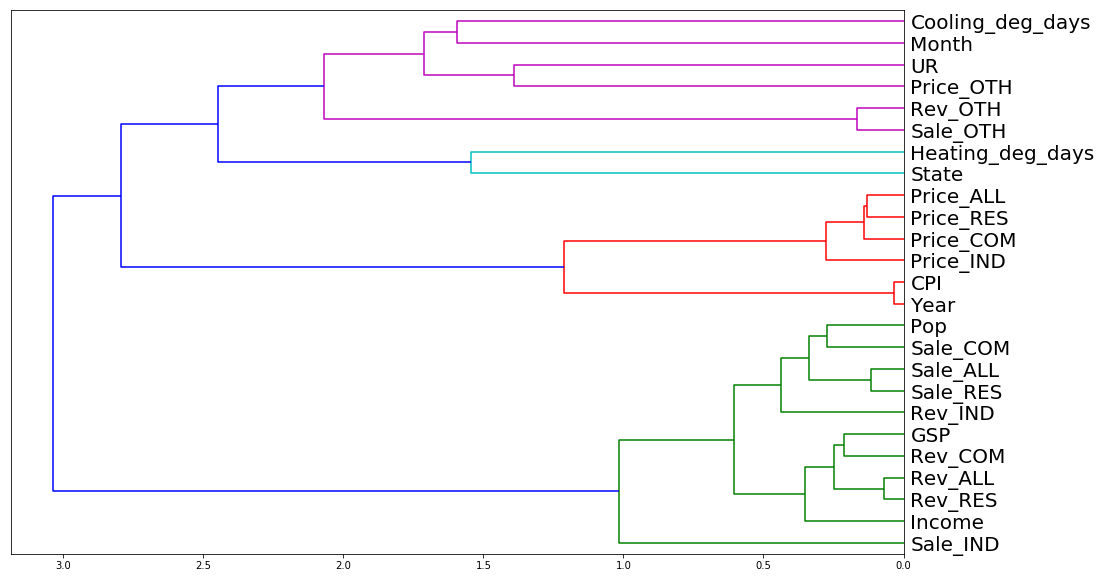

In [7]:
from scipy.cluster import hierarchy as hc

# Redundant Features
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=20)
plt.show()

Observation 

- Need to watch out for sale, rev, income, and gsp, which depends on population. 
- Drop all 'OTH' and 'ALL' columns 
- CPI is close to price of electricity
- Sale and revenue are correlated

In [10]:
df.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI'],
      dtype='object')

In [13]:
col = 'Sale_RES'
# relationship with Sale_RES
to_plot = ['Year', 'Month', 'Sale_COM', 'Sale_IND',
       'Price_RES', 'Rev_RES','Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI']

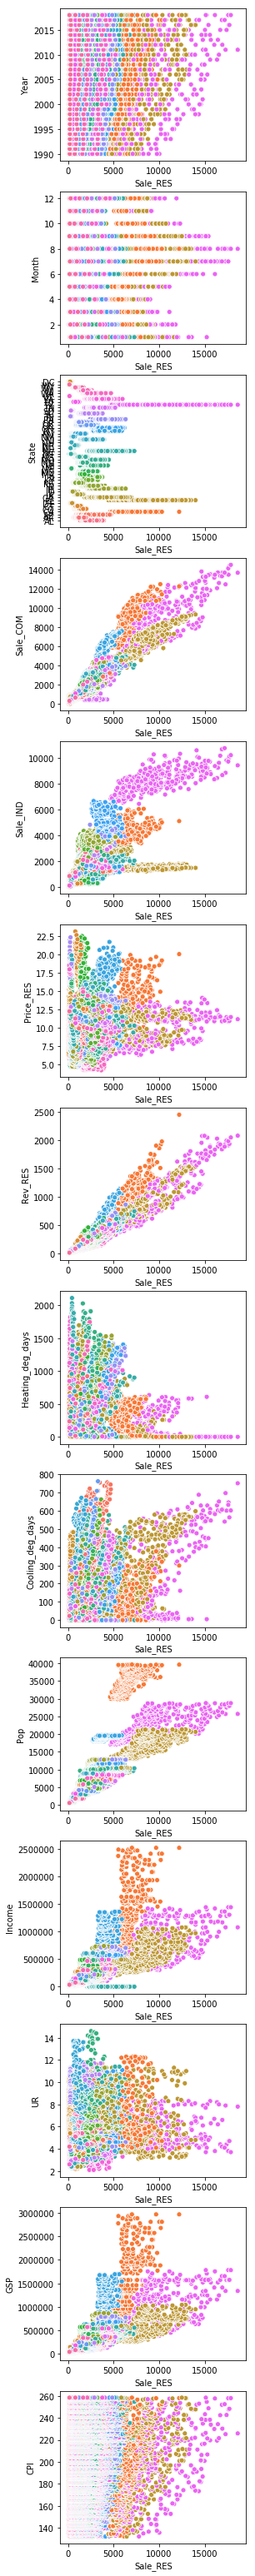

In [21]:
nplots = len(to_plot)
_, ax = plt.subplots(nplots,1,figsize=(4,4*nplots))

for i, y in enumerate(to_plot):
    sns.scatterplot(data=df,hue='State',x=col,y=y,ax=ax[i], legend=False )

Divide sale, rev, income, and gsp by population 

In [26]:
df['Sale_RES_norm'] = df['Sale_RES']/df['Pop']
df['Sale_COM_norm'] = df['Sale_COM']/df['Pop']
df['Sale_IND_norm'] = df['Sale_IND']/df['Pop']

df['Rev_RES_norm'] = df['Rev_RES']/df['Pop']
df['Rev_COM_norm'] = df['Rev_COM']/df['Pop']
df['Rev_IND_norm'] = df['Rev_IND']/df['Pop']

df['Income_norm'] = df['Income']/df['Pop']
df['GSP_norm'] = df['GSP']/df['Pop']

In [24]:
def plot_re(col,to_plot,df):
    
    nplots = len(to_plot)
    _, ax = plt.subplots(nplots,1,figsize=(4,4*nplots))

    for i, y in enumerate(to_plot):
        sns.scatterplot(data=df,hue='State',x=col,y=y,ax=ax[i], legend=False,alpha=0.5 )
    

In [27]:
df.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income',
       'UR', 'GSP', 'CPI', 'Sale_RES_norm', 'Sale_COM_norm', 'Sale_IND_norm',
       'Rev_RES_norm', 'Rev_COM_norm', 'Rev_IND_norm', 'Income_norm',
       'GSP_norm'],
      dtype='object')

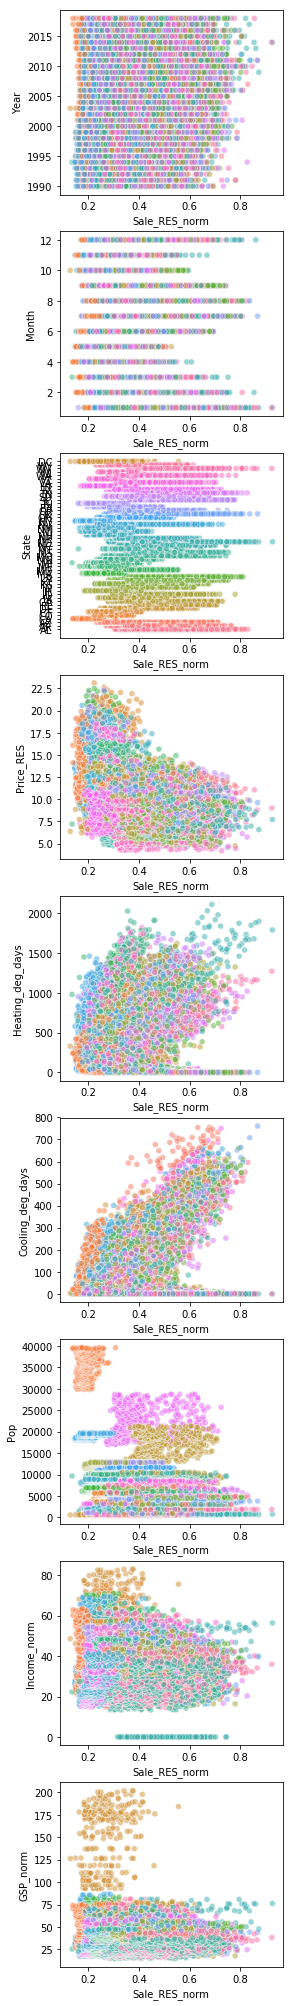

In [28]:
col = 'Sale_RES_norm'
# relationship with Sale_RES
to_plot = ['Year', 'Month', 'State',  'Price_RES', 
           'Heating_deg_days', 'Cooling_deg_days', 'Pop','Income_norm','GSP_norm']
plot_re(col,to_plot,df)

Electricity price over time 

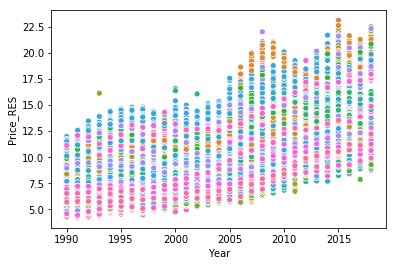

In [32]:
sns.scatterplot(data=df, x='Year',y='Price_RES',hue='State',legend=False)

Electricity price variation over the month for 2017 and 2018

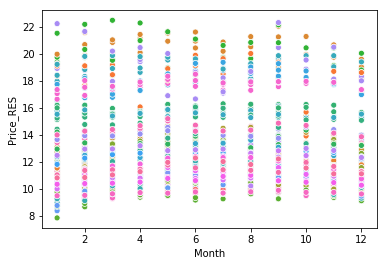

In [37]:
temp = df[df['Year'].isin([2016,2017,2018])]
sns.scatterplot(data=temp, x='Month',y='Price_RES',hue='State',legend=False)

# Maps

In [105]:
from bokeh.sampledata.us_states import data as states
from bokeh.io import output_file, output_notebook, show,curdoc, reset_output,export_png
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, CategoricalColorMapper, Slider, DateRangeSlider,
    DateSlider, SingleIntervalTicker, LinearAxis,Legend, LegendItem, ColorBar, LinearColorMapper
)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import STAMEN_TERRAIN,CARTODBPOSITRON_RETINA
from bokeh.layouts import widgetbox,row, column, gridplot
from matplotlib import cm

In [65]:
del states["HI"]
del states["AK"]

In [95]:
len(state_colors)

49

In [96]:
states.keys()

dict_keys(['NV', 'AZ', 'WI', 'GA', 'KS', 'CT', 'IN', 'ME', 'MA', 'MT', 'MD', 'AR', 'AL', 'VA', 'NE', 'KY', 'NY', 'CO', 'VT', 'SD', 'MI', 'MO', 'NC', 'RI', 'ID', 'DE', 'DC', 'NH', 'MN', 'ND', 'OK', 'IA', 'TN', 'FL', 'LA', 'NM', 'WY', 'PA', 'SC', 'UT', 'WV', 'WA', 'MS', 'OR', 'IL', 'NJ', 'CA', 'OH', 'TX'])

In [100]:
norm(value_dict['CA'])

0.7748729121278142

In [118]:
# prepare colormap 
col = 'Price_RES'
temp = df[(df['Year']==2018)& ~(df['State'].isin(['AK','HI']))]
vmin = temp[col].min()
vmax = temp[col].max()
#normalize item number values to colormap
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
#obtain state-value dictionary
value_dict = temp[['State',col]].set_index('State').to_dict()[col]

#colormap values = viridis, jet, spectral
state_colors = [cm.Blues(norm(value_dict[code])) for code in states]
state_colors = [cm.colors.to_hex(color) for color in state_colors]

# polygon
state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]


p = figure(title="Residential Electricity Price 2018", toolbar_location="left",
           plot_width=600, plot_height=400)

p.patches(state_xs, state_ys,
          fill_color=state_colors, fill_alpha=0.7,
          line_color="grey", line_width=1)

color_mapper = LinearColorMapper(palette="Blues8", low=vmin, high=vmax)
color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=5, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

show(p)

# Map

In [332]:
combine = pd.read_csv(cleanfolder+'combine.csv').dropna()
combine['Year-Month'] = pd.to_datetime(combine['Year-Month'])
combine = combine.set_index('Year-Month')
# set State and Regions columns as category 
combine['State'] = combine['State'].astype('category')
combine['Regions'] = combine['Regions'].astype('category')

In [333]:
combine['Sale_RES_per_cap'] = combine['Sale_RES']/combine['Pop']
combine['Sale_COM_per_cap'] = combine['Sale_COM']/combine['Pop']
combine['Sale_IND_per_cap'] = combine['Sale_IND']/combine['Pop']
combine['Cus_RES_per_cap'] = combine['Cus_RES']/combine['Pop']
combine['Cus_COM_per_cap'] = combine['Cus_COM']/combine['Pop']
combine['Cus_IND_per_cap'] = combine['Cus_IND']/combine['Pop']

In [334]:
state_location = pd.read_html('https://inkplant.com/code/state-latitudes-longitudes')[0]
state_location['State'] = state_location['State'].replace(to_replace=us_state_abbrev)

In [335]:
combine = combine.merge(state_location,on='State')

In [336]:
combine.columns

Index(['Year', 'Month', 'State', 'Sale_RES', 'Sale_COM', 'Sale_IND',
       'Sale_OTH', 'Sale_ALL', 'Price_RES', 'Price_COM', 'Price_IND',
       'Price_OTH', 'Price_ALL', 'Rev_RES', 'Rev_COM', 'Rev_IND', 'Rev_OTH',
       'Rev_ALL', 'Cus_RES', 'Cus_COM', 'Cus_IND', 'Cus_OTH', 'Cus_ALL',
       'Heating_deg_days', 'Cooling_deg_days', 'Pop', 'Income', 'UR', 'GSP',
       'CPI', 'Regions', 'Sale_ALL_no_OTH', 'Sale_RES_per_cap',
       'Sale_COM_per_cap', 'Sale_IND_per_cap', 'Cus_RES_per_cap',
       'Cus_COM_per_cap', 'Cus_IND_per_cap', 'Latitude', 'Longitude'],
      dtype='object')

In [462]:
def get_color(series,cmap=cm.Blues):
    ''' obtain hex color map for each value'''
    vmin = series.min()
    vmax = series.max()
    #normalize item number values to colormap
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    #colormap values = viridis, jet, spectral
    state_colors = [cmap(norm(value)) for value in series.values]
    state_colors = [cm.colors.to_hex(color) for color in state_colors]
    return state_colors

In [478]:
# select data in 2018
data = combine[combine['Year']==2018]
# group by State and obtain average each columns except for the Regions
data = data[['State','Regions','Latitude','Sale_RES_per_cap',
             'Sale_COM_per_cap','Sale_IND_per_cap'
            ]].groupby('State',as_index=False
                      ).agg({'Latitude':'mean','Sale_RES_per_cap':'mean',
             'Sale_COM_per_cap':'mean','Sale_IND_per_cap':'mean',
                             'Regions':'last'
    
})

In [479]:
# another df groupby 'Region'
data2 = combine[combine['Year']==2018].copy()
data2 = data2[['Regions','Latitude','Sale_IND_per_cap']].groupby('Regions',as_index=False).mean()
# assigned industrial color map
ind_colors = get_color(data2['Sale_IND_per_cap'],cm.Paired)
data2['IND_color'] = ind_colors
# merge with the first data df 
data = data.merge(data2.drop('Sale_IND_per_cap',axis=1),on='Regions')

In [480]:
# sort data 
data = data.sort_values(['Latitude_y','Latitude_x'],ascending=True)

In [481]:
res_colors = get_color(data['Sale_RES_per_cap'])
ind_colors = data['IND_color'].values
com_colors = get_color(data['Sale_COM_per_cap'],cm.YlGn)

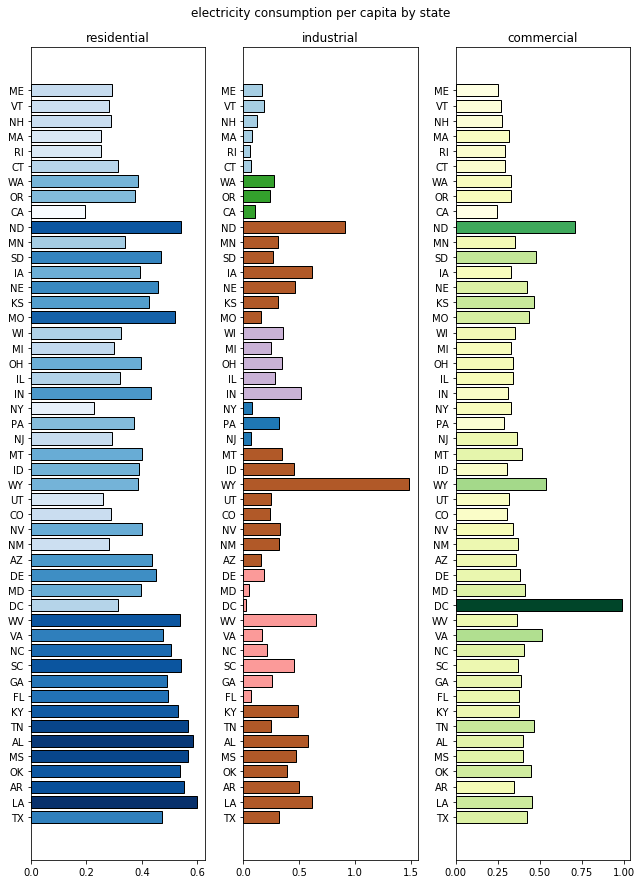

In [482]:
fig, ax = plt.subplots(1,3, figsize=(9,12))
fig.suptitle('electricity consumption per capita by state',y=1.02)
ax[0].barh(data['State'],data['Sale_RES_per_cap'],color=res_colors,edgecolor='black')
ax[0].set_xlabel('residential',size=12)
ax[0].xaxis.set_label_coords(0.5, 1.02)


ax[1].barh(data['State'],data['Sale_IND_per_cap'],color=ind_colors,edgecolor='black')
ax[1].set_xlabel('industrial',size=12)
ax[1].xaxis.set_label_coords(0.5, 1.02)

ax[2].barh(data['State'],data['Sale_COM_per_cap'],color=com_colors,edgecolor='black')
ax[2].set_xlabel('commercial',size=12)
ax[2].xaxis.set_label_coords(0.5, 1.02)


plt.tight_layout()

In [394]:
data = combine[combine['Year']==2018]
data = data[['Regions','Latitude','Sale_RES_per_cap','Sale_COM_per_cap','Sale_IND_per_cap']].groupby('Regions',as_index=False).mean()
             
#    'Cus_RES_per_cap','Cus_COM_per_cap','Cus_IND_per_cap']]
data = data.sort_values(['Latitude'],ascending=True)
data.head()

Regions   Latitude  Sale_RES_per_cap  Sale_COM_per_cap  \
8  West South Central   33.189770          0.540640          0.418517   
1  East South Central   34.741076          0.562670          0.411157   
6      South Atlantic   35.981592          0.468392          0.466350   
3            Mountain   40.001498          0.355405          0.365179   
2     Middle Atlantic   41.018461          0.297519          0.327390   

   Sale_IND_per_cap  
8          0.455086  
1          0.448990  
6          0.229499  
3          0.448089  
2          0.153030

In [395]:
res_colors = get_color(data['Sale_RES_per_cap'])
ind_colors = get_color(data['Sale_IND_per_cap'])
com_colors = get_color(data['Sale_COM_per_cap'])

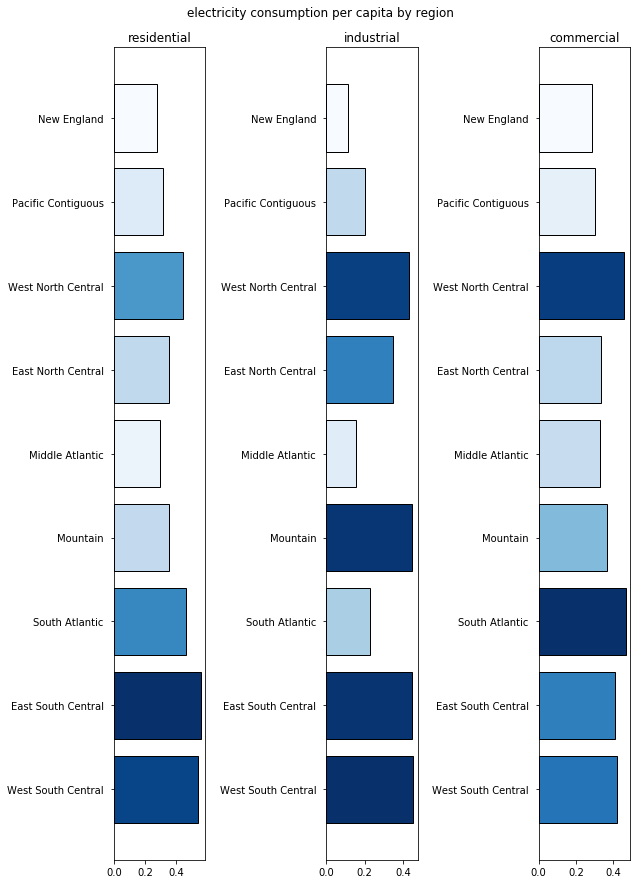

In [397]:
fig, ax = plt.subplots(1,3, figsize=(9,12))
fig.suptitle('electricity consumption per capita by region',y=1.02)
ax[0].barh(data['Regions'],data['Sale_RES_per_cap'],color=res_colors,edgecolor='black')
ax[0].set_xlabel('residential',size=12)
ax[0].xaxis.set_label_coords(0.5, 1.02)

ax[1].barh(data['Regions'],data['Sale_IND_per_cap'],color=ind_colors,edgecolor='black')
ax[1].set_xlabel('industrial',size=12)
ax[1].xaxis.set_label_coords(0.5, 1.02)

ax[2].barh(data['Regions'],data['Sale_COM_per_cap'],color=com_colors,edgecolor='black')
ax[2].set_xlabel('commercial',size=12)
ax[2].xaxis.set_label_coords(0.5, 1.02)

plt.tight_layout()

In [259]:
# Import libraries
import folium
 
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
    
state_geo = 'us-states.json'
 
# Load the unemployment value of each state
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
data = combine.loc['2018']
 
# Initialize the map:
m = folium.Map(location=[40, -98], zoom_start=4, width=700, height=450)
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=data,
 columns=['State', 'Sale_RES_per_cap'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='Electricity Consumption per Capita in Residential Sector'
)

folium.LayerControl().add_to(m)

display(m)

In [244]:
# Import libraries
import folium
 
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
# You have to download this file and set the directory where you saved it
    
state_geo = 'us-states.json'
 
# Load the unemployment value of each state
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
data = sale_industry.loc['2018']
 
# Initialize the map:
m = folium.Map(location=[40, -98], zoom_start=4, width=700, height=450)
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=data,
 columns=['State', 'Sale_IND_per_cap'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Electricity Consumption per Capita in Industry Sector'
)

folium.LayerControl().add_to(m)

display(m)

In [488]:
# select data in 2018
data1 = combine[combine['Year']==2018]
# group by State and obtain average each columns except for the Regions
data1 = data1[['State','Regions','Latitude','Longitude','Sale_RES_per_cap',
             'Sale_COM_per_cap','Sale_IND_per_cap'
            ]].groupby('State',as_index=False
                      ).agg({'Latitude':'mean','Longitude':'mean','Sale_RES_per_cap':'mean',
             'Sale_COM_per_cap':'mean','Sale_IND_per_cap':'mean',
                             'Regions':'last'
    
})

In [512]:
data11 = data1[['State','Latitude','Longitude','Sale_RES_per_cap']].sort_values('Sale_RES_per_cap',ascending=False).head(10)
data12 = data1[['State','Latitude','Longitude','Sale_IND_per_cap']].sort_values('Sale_IND_per_cap',ascending=False).head(10)
data13 = data1[['State','Latitude','Longitude','Sale_COM_per_cap']].sort_values('Sale_COM_per_cap',ascending=False).head(10)

In [526]:
data11.head()

State   Latitude  Longitude  Sale_RES_per_cap
16    LA  31.169546 -91.867805          0.599297
0     AL  32.806671 -86.791130          0.585505
40    TN  35.747845 -86.692345          0.567167
23    MS  32.741646 -89.678696          0.565625
1     AR  34.969704 -92.373123          0.551443

In [525]:
set1 = set(data11['State'].unique())
set2 = set(data12['State'].unique())
set3 = set(data13['State'].unique())
set_all = set1.union(set2,set3)
print(set1)

{'WV', 'SC', 'AR', 'AL', 'ND', 'TN', 'LA', 'OK', 'KY', 'MS'}


In [527]:


# Make an empty map
m = folium.Map(location=[40, -98], zoom_start=4, width=700, height=450)
 
# I can add marker one by one on the map
for i in range(0,len(data11)):
   folium.Circle(
      location=[data11.iloc[i]['Latitude'], data11.iloc[i]['Longitude']],
       popup=data11.iloc[i]['State'],
      radius=data11.iloc[i]['Sale_RES_per_cap']*100000,
      color='crimson',
       linewidth=1,
      fill=True,
      fill_color='crimson'
   ).add_to(m)
 
    
# I can add marker one by one on the map
for i in range(0,len(data12)):
   folium.Circle(
      location=[data12.iloc[i]['Latitude']+1, data12.iloc[i]['Longitude']],
       popup=data12.iloc[i]['State'],
      radius=data12.iloc[i]['Sale_IND_per_cap']*100000,
      color='blue',
       linewidth=1,
      fill=True,
      fill_color='blue'
   ).add_to(m)

# I can add marker one by one on the map
for i in range(0,len(data12)):
   folium.Circle(
      location=[data13.iloc[i]['Latitude'], data13.iloc[i]['Longitude']-1],
       popup=data13.iloc[i]['State'],
      radius=data13.iloc[i]['Sale_COM_per_cap']*100000,
      fill=True,
      fill_color='green'
   ).add_to(m)

display(m)

In [528]:
data13.head()

State   Latitude   Longitude  Sale_COM_per_cap
6     DC  38.897438  -77.026817          0.988075
26    ND  47.528912  -99.784012          0.712266
48    WY  42.755966 -107.302490          0.537236
43    VA  37.769337  -78.169968          0.514031
39    SD  44.299782  -99.438828          0.478253

In [ ]:
def make_map(countyseries, skip=[], stateskip=['Alaska', 'Hawaii'], color=None, ax=None):
    if not ax:
        fig = plt.figure(figsize=(16, 12))
        ax = plt.gca()

        for state in state2poly.keys():
            if state in stateskip:
                continue
            draw_state(ax, state,  ec='k')
        
    for county in countyseries:
        if county in skip:
            continue
        if color:
            draw_county(ax, county,  ec='k', color=color)
        else:
            draw_county(ax, county,  ec='k') 

    
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlim(-180, -60)
    ax.set_xlim(-132, -60)
    ax.set_ylim(20, 59)
    return ax

Data Separation

In [124]:
len(df.index)/5

3364.2

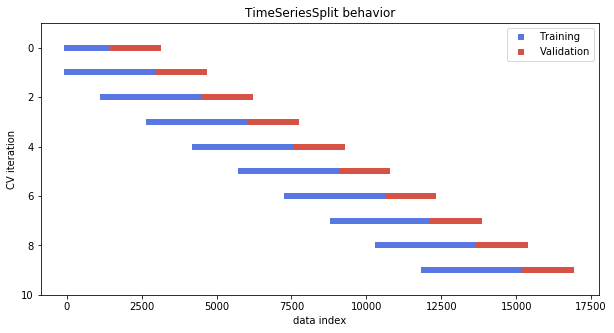

In [126]:
# Import and initialize the cross-validation iterator
from sklearn.model_selection import TimeSeriesSplit

date = df.index

cv = TimeSeriesSplit(n_splits=10,max_train_size=int(len(df.index)/5))

fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr,tt) in enumerate(cv.split(date)):
    # Plot training and test indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], 
                    marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], 
                    marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', 
           xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

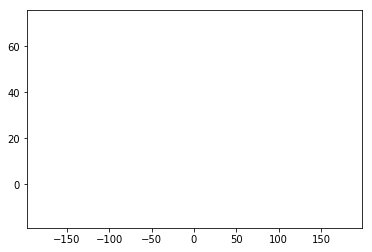

In [543]:
_, ax = plt.subplots()
for state in state2poly.keys():
    draw_state(ax, state,  ec='k')

In [542]:
def draw_state(subplot, name, **kwargs):
    global _color_idx
    if name not in state2poly:
        if get_statename(name) in state2poly:
            name = get_statename(name)
            
    kwargs['color'] = "#FFFFFF"
    for polygon in state2poly[name]:
        draw_polygon(subplot, polygon, **kwargs)

In [538]:
from collections import defaultdict
import simplejson as json

with open('./us_state_map.geojson','r') as fp:
    statedata = json.load(fp)
    
state2poly = defaultdict(list)

for f in statedata['features']:
    state = f['properties']['NAME']
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

In [539]:
def draw_polygon(subplot, coords, **kwargs):
    xs, ys = zip(*coords)
    kwargs['alpha']=0.5
    subplot.fill(xs, ys, **kwargs)

In [545]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math



ModuleNotFoundError: No module named 'conda'

In [3]:
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib.pyplot'

In [4]:
import geopandas as gpd

ImportError: DLL load failed: The specified module could not be found.

In [548]:
# Import packages
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

ImportError: DLL load failed: The specified module could not be found.

In [3]:
import simplejson as json
from collections import defaultdict
# load state map json files 
with open('./us_state_map.geojson','r') as fp:
    statedata = json.load(fp)
    
_color_idx = 0

state2poly = defaultdict(list)
for f in statedata['features']:
    state = f['properties']['NAME']
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

In [23]:
# function to draw polygon
def draw_polygon(subplot, coords):
    xs, ys = zip(*coords)
    #kwargs['alpha']=0.5
    subplot.fill(xs, ys, c='lightblue',alpha=0.5)
    subplot.plot(xs, ys, c='lightblue')

In [24]:
def draw_state(subplot, name):
    """   
    Automatically draws a filled shape representing the state in
    subplot.  *state* is the full name of the state.
    """
    global _color_idx

    for polygon in state2poly[name]:
        draw_polygon(subplot, polygon)

(25, 50)

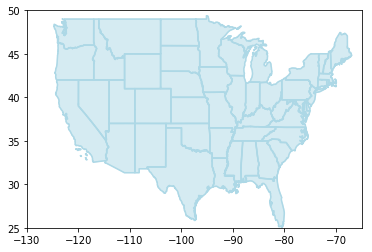

In [25]:
fig,ax = plt.subplots()
for state in state2poly.keys():
    draw_state(ax, state)

plt.xlim([-130,-65])
plt.ylim([25,50])

In [1]:
with open('./us_state_map.geojson','r') as fp:
    statedata = json.load(fp)

In [6]:
len(statedata['features'])

56

In [4]:
statedata

{'type': 'FeatureCollection',
 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4269'}},
 'features': [{'type': 'Feature',
   'properties': {'STATEFP': '04',
    'STATENS': '01779777',
    'AFFGEOID': '0400000US04',
    'GEOID': '04',
    'STUSPS': 'AZ',
    'NAME': 'Arizona',
    'LSAD': '00',
    'ALAND': 294205037082.0,
    'AWATER': 1027846143.0},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-114.813991, 32.497231],
      [-114.812316, 32.500054],
      [-114.813753, 32.50426],
      [-114.813694, 32.505065],
      [-114.813164, 32.505594],
      [-114.812635, 32.506918],
      [-114.81237, 32.507712],
      [-114.810159, 32.508383],
      [-114.807726, 32.508726],
      [-114.806017, 32.510094],
      [-114.804694, 32.512476],
      [-114.804429, 32.514594],
      [-114.804958, 32.517506],
      [-114.809723, 32.520153],
      [-114.811576, 32.523594],
      [-114.810563, 32.527666],
      [-114.8064, 32.531192],
      [-114.802181, 32.536414],
   

In [11]:
for f in statedata['features']:
    print(f['properties']['STUSPS'])
    print(f['geometry']['type'])

AZ
Polygon
AR
Polygon
CA
MultiPolygon
CT
Polygon
GA
Polygon
HI
MultiPolygon
ID
Polygon
IN
Polygon
IA
Polygon
KY
MultiPolygon
LA
MultiPolygon
MD
MultiPolygon
MN
Polygon
MS
MultiPolygon
MT
Polygon
NV
Polygon
NJ
Polygon
NY
MultiPolygon
OH
MultiPolygon
OK
Polygon
PA
Polygon
SC
Polygon
SD
Polygon
UT
Polygon
VT
Polygon
WV
Polygon
WY
Polygon
NH
Polygon
TN
Polygon
PR
MultiPolygon
FL
MultiPolygon
MA
MultiPolygon
NC
MultiPolygon
VA
MultiPolygon
AL
MultiPolygon
AK
MultiPolygon
CO
Polygon
DE
MultiPolygon
DC
Polygon
IL
Polygon
KS
Polygon
ME
MultiPolygon
MI
MultiPolygon
MO
Polygon
NE
Polygon
NM
Polygon
ND
Polygon
OR
Polygon
RI
MultiPolygon
TX
MultiPolygon
WA
MultiPolygon
WI
MultiPolygon
AS
MultiPolygon
GU
MultiPolygon
MP
MultiPolygon
VI
MultiPolygon


In [13]:
from collections import defaultdict
state2poly = defaultdict(list)
for f in statedata['features']:
    state = f['properties']['STUSPS']
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

In [21]:
state2poly['VI']

[[[-64.6343228071426, 17.7958906266761],
  [-64.6221417211023, 17.7964563934427],
  [-64.6066925388073, 17.7905157529623],
  [-64.6072867381263, 17.784857816363697],
  [-64.622061, 17.783843],
  [-64.63254020918549, 17.7871210125134],
  [-64.6343228071426, 17.7958906266761]],
 [[-64.797864, 18.337156],
  [-64.786926, 18.35266],
  [-64.76743, 18.354141],
  [-64.75506240451949, 18.3540461714791],
  [-64.752324, 18.370797],
  [-64.7475849416968, 18.3728605423142],
  [-64.734224, 18.37041],
  [-64.733349, 18.363475],
  [-64.721235, 18.3626],
  [-64.719478, 18.366689],
  [-64.713305, 18.367283],
  [-64.704202, 18.361044],
  [-64.694805, 18.361902],
  [-64.68796509769919, 18.3587031900871],
  [-64.6863338184444, 18.353484164010002],
  [-64.678230494101, 18.3484417390935],
  [-64.674244, 18.3503],
  [-64.660866, 18.343824],
  [-64.662893, 18.336243],
  [-64.6675, 18.335996],
  [-64.670146, 18.330304],
  [-64.677062, 18.332247],
  [-64.692189, 18.339148],
  [-64.704766, 18.340338],
  [-64.7009

In [29]:
state2poly.pop('VI',None)

[[[-64.6343228071426, 17.7958906266761],
  [-64.6221417211023, 17.7964563934427],
  [-64.6066925388073, 17.7905157529623],
  [-64.6072867381263, 17.784857816363697],
  [-64.622061, 17.783843],
  [-64.63254020918549, 17.7871210125134],
  [-64.6343228071426, 17.7958906266761]],
 [[-64.797864, 18.337156],
  [-64.786926, 18.35266],
  [-64.76743, 18.354141],
  [-64.75506240451949, 18.3540461714791],
  [-64.752324, 18.370797],
  [-64.7475849416968, 18.3728605423142],
  [-64.734224, 18.37041],
  [-64.733349, 18.363475],
  [-64.721235, 18.3626],
  [-64.719478, 18.366689],
  [-64.713305, 18.367283],
  [-64.704202, 18.361044],
  [-64.694805, 18.361902],
  [-64.68796509769919, 18.3587031900871],
  [-64.6863338184444, 18.353484164010002],
  [-64.678230494101, 18.3484417390935],
  [-64.674244, 18.3503],
  [-64.660866, 18.343824],
  [-64.662893, 18.336243],
  [-64.6675, 18.335996],
  [-64.670146, 18.330304],
  [-64.677062, 18.332247],
  [-64.692189, 18.339148],
  [-64.704766, 18.340338],
  [-64.7009

In [30]:
len(state2poly.keys())

52

In [31]:
state2poly.keys()

dict_keys(['AZ', 'AR', 'CA', 'CT', 'GA', 'HI', 'ID', 'IN', 'IA', 'KY', 'LA', 'MD', 'MN', 'MS', 'MT', 'NV', 'NJ', 'NY', 'OH', 'OK', 'PA', 'SC', 'SD', 'UT', 'VT', 'WV', 'WY', 'NH', 'TN', 'PR', 'FL', 'MA', 'NC', 'VA', 'AL', 'AK', 'CO', 'DE', 'DC', 'IL', 'KS', 'ME', 'MI', 'MO', 'NE', 'NM', 'ND', 'OR', 'RI', 'TX', 'WA', 'WI'])

In [33]:
state2poly = dict(state2poly)

In [35]:
with open('statemap.json', 'w') as f:
    json.dump(state2poly, f)

In [36]:
with open('statemap.json','r') as fp:
    statemap = json.load(fp)

In [37]:
statemap.keys()

dict_keys(['AZ', 'AR', 'CA', 'CT', 'GA', 'HI', 'ID', 'IN', 'IA', 'KY', 'LA', 'MD', 'MN', 'MS', 'MT', 'NV', 'NJ', 'NY', 'OH', 'OK', 'PA', 'SC', 'SD', 'UT', 'VT', 'WV', 'WY', 'NH', 'TN', 'PR', 'FL', 'MA', 'NC', 'VA', 'AL', 'AK', 'CO', 'DE', 'DC', 'IL', 'KS', 'ME', 'MI', 'MO', 'NE', 'NM', 'ND', 'OR', 'RI', 'TX', 'WA', 'WI'])

In [53]:
def draw_state(subplot, name):
    """   
    Automatically draws a filled shape representing the state in
    subplot.  
    name is abbreviation of the state.
    """
    polygons = statemap[name]
    for polygon in polygons:
        xs, ys = zip(*coords)
    #kwargs['alpha']=0.5
        subplot.fill(xs, ys, c='lightblue',alpha=0.5)
        subplot.plot(xs, ys, c='blue')

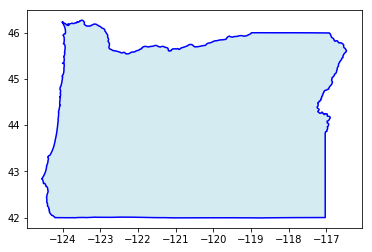

In [56]:
fig,ax = plt.subplots()
draw_state(ax,'CT')

In [49]:
x,y = zip(*statemap['CA'][0])